In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pyvis import network as net
import json
from os import listdir

import datashader as ds
import datashader.transfer_functions as tf
from datashader.bundling import hammer_bundle

Load the JSON files 

In [2]:
def load_data(directory):
    # Load json files 
    json_data_asctb = {}
    for filename in listdir(directory):
        if '.json' in filename:
            # print(filename)
            with open(f'{directory}{filename}', encoding='utf8') as json_file:
                data = json.load(json_file)

            json_data_asctb[filename[:-5]] = data
    return json_data_asctb

In [3]:
json_data_asctb=load_data('./asct+b/v12/')

Order of the organs

In [4]:
griffin_organ_order = ['lung', 'heart', 'brain', 'eye', 'skin', 'thymus', 'lymph_nodes', 'spleen', 
                       'liver', 'pancreas', 'small_intestine', 'large_intestine', 'kidney', 
                       'urinary_bladder', 'ureter', 'prostate', 'ovary', 'fallopian_tube', 
                       'uterus', 'placenta', 'knee', 'bone_marrow']

In [5]:
json_data_asctb = {organ: json_data_asctb[organ] for organ in griffin_organ_order}

In [6]:
json_data_asctb.keys()

dict_keys(['lung', 'heart', 'brain', 'eye', 'skin', 'thymus', 'lymph_nodes', 'spleen', 'liver', 'pancreas', 'small_intestine', 'large_intestine', 'kidney', 'urinary_bladder', 'ureter', 'prostate', 'ovary', 'fallopian_tube', 'uterus', 'placenta', 'knee', 'bone_marrow'])

In [7]:
json_data_asctb['skin']['nodes'][0]

{'id': 0,
 'type': 'AS',
 'name': 'Body',
 'metadata': {'name': 'Body',
  'ontologyId': 'UBERON:0013702',
  'ontologyType': 'UBERON',
  'ontologyTypeId': '0013702',
  'label': 'body proper',
  'references': [{'id': 'PMID: 8689554.',
    'doi': 'DOI: 10.1146/annurev.cb.11.110195.001011',
    'notes': 'Fuchs E. Keratins and the skin. Annu Rev Cell Dev Biol. 1995;11:123-53.'},
   {'id': 'PMID: 8752847',
    'doi': 'DOI: 10.1111/1523-1747.ep12298323',
    'notes': 'Robinson NA, LaCelle PT, Eckert RL. Involucrin is a covalently crosslinked constituent of highly purified epidermal corneocytes: evidence for a common pattern of involucrin crosslinking in vivo and in vitro. J Invest Dermatol. 1996 Jul;107(1):101-7.'},
   {'id': 'PMID: 2248957',
    'doi': 'DOI: 10.1021/bi00492a018',
    'notes': 'Gan SQ, McBride OW, Idler WW, Markova N, Steinert PM. Organization, structure, and polymorphisms of the human profilaggrin gene. Biochemistry. 1990 Oct 9;29(40):9432-40. DOI: 10.1021/bi00492a018. Errat

In [8]:
def combine_data(json_dat, remove_ctct=True, combine=True, blood=False, correct=False):
    """
    combine_data takes the json data of the organs and returns the node and edge lists in pandas dataframes

    :param json_dat: data of all the organs in a json format that was loaded by the load_data function
    :param remove_ctct: There should not be edges between CT and CT, however sometimes there can be mistakes in the data files. 
    :param combine: if true then the organs are combined into one network, and the function ouputs 2 dataframes: nodes and edges. 
                    if false, then the organs are not combined, the function returns a node and an edge table for each organ.
    :param blood: By default it is false, and in this case the function ignores the following tables: 'blood_pelvis', 'blood_vasculature', 
                 'lymph_vasculature', 'peripheral_nervous_system'. If true, then 'blood_vasculature' is not excluded.
    :param correct: unused parameter. There were two apparent mistakes in the v1.1 version: vasculature branch in lung is not connected 
                    to the respiratory system, and there is an additional node in the fallopian tube, called 'wall of uterine tube', 
                    that should not be there. In v1.2 these are corrected but Pulmonary Vascular System is not connected to 'lung'
    """ 
    nodes_data = []
    edges_data = []
    organ_names = ['body']
    
    # The numbering of the nodes starts from 1 in each organ
    # If we combine the organs, we need a new id
    node_id_start_point = 1 
    
    #Add the 'body' node to the nodes data:
    body_df = pd.DataFrame(json_dat['brain']['nodes']).head(1)
    body_df.index = body_df['id']
    body_df['id_old'] = 0
    body_df['organ'] = 'body'
    body_df['ontology_id'] = 'UBERON:0013702'
    
    nodes_data += [body_df[['id', 'id_old', 'name', 'type', 'organ', 'ontology_id']]]
    
    if not combine:
        body_data = body_df[['id', 'id_old', 'name', 'type', 'organ', 'ontology_id']].copy()
    
    if blood:
        exclude = ['blood_pelvis', 'lymph_vasculature', 'peripheral_nervous_system']
    else:
        exclude = ['blood_pelvis', 'blood_vasculature', 'lymph_vasculature', 'peripheral_nervous_system']
    
    for name in json_dat.keys():
        if name in exclude:
            continue
        else:
            # print(name)
            organ_names += [name]
            # Combine nodes:
            organ_nodes = pd.DataFrame(json_dat[name]['nodes']).iloc[1:,:]
            not_as_ct_nodes = organ_nodes[~organ_nodes['type'].isin(['AS', 'CT'])]['id'] #filter for AS and CT
            organ_nodes['id_old'] = organ_nodes['id'].copy()
            if combine:
                organ_nodes['id'] = organ_nodes['id'].add(node_id_start_point-1)
            organ_nodes.index = organ_nodes['id']
            # organ_nodes = organ_nodes.drop(columns=['id'])
            organ_nodes = organ_nodes[organ_nodes['type'].isin(['AS', 'CT'])]
            organ_nodes['organ'] = name
            organ_nodes['ontology_id'] = organ_nodes['metadata'].apply(lambda x: x['ontologyId'])
            organ_nodes = organ_nodes[['id', 'id_old', 'name', 'type', 'organ', 'ontology_id']]
            

            # Combine edges:
            organ_edges = pd.DataFrame(json_dat[name]['edges'])
            ## Remove CT-CT edges:
            if remove_ctct:
                organ_nodes_original = pd.DataFrame(json_dat[name]['nodes'])
                organ_nodes_original.index = organ_nodes_original['id']
                organ_edges['source_type'] = organ_edges['source'].apply(lambda x: organ_nodes_original.loc[x]['type'])
                organ_edges['target_type'] = organ_edges['target'].apply(lambda x: organ_nodes_original.loc[x]['type'])
                organ_edges = organ_edges[(organ_edges['source_type']=='AS')|(organ_edges['target_type']=='AS')]
            ##rename edges due to colliding ids
            organ_network = nx.from_pandas_edgelist(organ_edges)
            #remove unnecessary edges:
            organ_network.remove_nodes_from(not_as_ct_nodes.to_list())
            #remove body-organ edge (we will ad it later)
            organ_network.remove_edge(0, 1)
            organ_network.remove_node(0)
            #rename nodes
            # organ_network = nx.relabel_nodes(organ_network, organ_nodes['name'].to_dict())
            if combine:
                organ_network = nx.convert_node_labels_to_integers(organ_network, first_label=node_id_start_point)
            #add body-organ edge
            # organ_network.add_node(0) 
            # nx.set_node_attributes(organ_network, {0: {"type": 'AS', "name": "Body", 'organ': 'body', 'ontology_id': 'UBERON:0013702'}})
            if combine:
                organ_network.add_edge(0, node_id_start_point)
                #v1.2 correction:
                if name=='lung':
                    #connect Pulmonary Vascular System to 
                    organ_network.add_edge(node_id_start_point, 42+node_id_start_point-1) 
                    
                #v1.1 corrections
                # if correct:
                    # if name=='fallopian_tube':
                    #     organ_nodes = organ_nodes[organ_nodes['name']!='wall of uterine tube']
                    # elif name=='lung':
                    #     organ_network.add_edge(34+node_id_start_point-1, node_id_start_point) 
                # else:
                    # if name=='fallopian_tube':
                    #     organ_network.add_edge(0, 72+node_id_start_point-1)                
                    # elif name=='lung':
                    #     organ_network.add_edge(34+node_id_start_point-1, 0) 
                    
            else:
                organ_network.add_edge(0, 1)
                #v1.2 correction:
                if name=='lung':
                    organ_network.add_edge(0, 42)
                #v1.1 corections:
                # if name=='fallopian_tube':
                #     organ_network.add_edge(0, 72)
                # elif name=='lung':
                #     organ_network.add_edge(0, 34)
                

            # Create CT duplicates
            organ_CT_nodes = organ_nodes[organ_nodes['type']=='CT'].copy()
            organ_CT_nodes['degree'] = dict(organ_network.degree(organ_CT_nodes['id'])).values()
            
            ct_nodes_to_copy = organ_CT_nodes[organ_CT_nodes['degree']>1]['id'].values
            edges_to_remove = []
            edges_to_add = []
            
            for ct_node in ct_nodes_to_copy:
                as_neighbors_of_ct = list(nx.neighbors(organ_network, ct_node))
                for ind, as_neighbor in enumerate(as_neighbors_of_ct):
                    if ind==0:
                        continue
                    else:
                        ct_node_details = organ_nodes.loc[ct_node].to_dict()
                        new_node_id = organ_nodes['id'].max()+1
                        ct_node_details['id'] = new_node_id
                        # organ_nodes = organ_nodes.append(ct_node_details, ignore_index=False)
                        organ_nodes.loc[new_node_id] = ct_node_details
                        
                        edges_to_remove += [(as_neighbor, ct_node)]
                        edges_to_add += [(as_neighbor, new_node_id)]
                        
            organ_network.remove_edges_from(edges_to_remove)
            organ_network.add_edges_from(edges_to_add)
                
            
            
            nodes_data += [organ_nodes]
            if not combine:
                nodes_data[-1] = pd.concat([body_data, nodes_data[-1]])
            
            node_id_start_point = max(organ_network.nodes)+1
            
            organ_edges = nx.to_pandas_edgelist(organ_network)[['source', 'target']]
            print(f"{name} is tree: {nx.is_tree(organ_network)}")
            edges_data += [organ_edges]

    if combine:
        return pd.concat(nodes_data, ignore_index=True), pd.concat(edges_data, ignore_index=True)
    else:
        return dict(zip(organ_names, nodes_data)), dict(zip(organ_names[1:], edges_data))

Combine the nodes and edges of the organs. (The code checks whether the graph of the organs are trees)

In [9]:
nodes, edges = combine_data(json_data_asctb, remove_ctct=True, combine=True)

lung is tree: True
heart is tree: True
brain is tree: True
eye is tree: True
skin is tree: True
thymus is tree: True
lymph_nodes is tree: True
spleen is tree: True
liver is tree: True
pancreas is tree: True
small_intestine is tree: True
large_intestine is tree: True
kidney is tree: True
urinary_bladder is tree: True
ureter is tree: True
prostate is tree: True
ovary is tree: True
fallopian_tube is tree: True
uterus is tree: True
placenta is tree: True
knee is tree: True
bone_marrow is tree: True


In [10]:
nodes.head()

,id,id_old,name,type,organ,ontology_id
0,0,0,Body,AS,body,UBERON:0013702
1,1,1,Respiratory System,AS,lung,UBERON:0001004
2,2,2,respiratory tract,AS,lung,UBERON:0000065
3,3,3,lower respiratory tract,AS,lung,UBERON:0001558
4,4,4,tracheobroncheal tree,AS,lung,UBERON:0007196


In [11]:
edges.head()

,source,target
0,1,2
1,1,0
2,1,42
3,2,3
4,3,4


## Construction of network 

In [12]:
whole_graph = nx.from_pandas_edgelist(edges)

In [13]:
def get_parent(node, graph):
    neighbors = nx.neighbors(graph, node)
    # print(len([x for x in neighbors if x<node]))
    return min(nx.neighbors(graph, node))

In [14]:
nodes['parent']= nodes['id'].apply(get_parent, graph=whole_graph)

In [15]:
nodes

,id,id_old,name,type,organ,ontology_id,parent
0,0,0,Body,AS,body,UBERON:0013702,1
1,1,1,Respiratory System,AS,lung,UBERON:0001004,0
2,2,2,respiratory tract,AS,lung,UBERON:0000065,1
3,3,3,lower respiratory tract,AS,lung,UBERON:0001558,2
4,4,4,tracheobroncheal tree,AS,lung,UBERON:0007196,3
...,...,...,...,...,...,...,...
2855,2855,44,mature CD8 T cell,CT,bone_marrow,,2812
2856,2856,45,NK lymphocytes,CT,bone_marrow,CL:0000814,2812
2857,2857,46,CD56 bright Natural Killer,CT,bone_marrow,CL:0000938,2812
2858,2858,47,mature Natural killer,CT,bone_marrow,CL:0000824,2812


In [16]:
nodes['color'] = nodes['type'].apply(lambda x: '#984ea' if x=='AS' else '#ff7f00')

In [17]:
nodes_json = nodes[['id', 'name', 'parent', 'type', 'ontology_id', 'color']].to_dict(orient='index')

In [18]:
del(nodes_json[0]['parent'])

In [19]:
nodes_json = [nodes_json[i] for i in nodes_json.keys()]

In [20]:
with open('human_atlas_v1.2', 'w', encoding='utf8') as f:
    f.write('[\n')
    for item in nodes_json:
        f.write(f"{json.dumps(item)},\n".replace("'", ''))
    f.write(']')

### Female network 

In [21]:
def construct_network(jason_data, filename, correct=False):
    nodes_df, edges_df = combine_data(jason_data, remove_ctct=True, combine=True, correct=correct)
    graph = nx.from_pandas_edgelist(edges_df)
    nodes_df['parent']= nodes_df['id'].apply(get_parent, graph=graph)
    nodes_df['color'] = nodes_df['type'].apply(lambda x: '#984ea3' if x=='AS' else '#ff7f00')
    
    nodes_df['organ_label'] = nodes_df.apply(lambda row: row['name'] if row['id_old']==1 else '', axis=1)
    nodes_json = nodes_df[['id', 'name', 'parent', 'type', 'ontology_id', 'color', 'organ', 'organ_label']].to_dict(orient='index')
    del(nodes_json[0]['parent'])
    nodes_json = [nodes_json[i] for i in nodes_json.keys()]
    
    with open(f'{filename}.json', 'w', encoding='utf8') as f:
        f.write('[\n')
        for item in nodes_json:
            f.write(f"{json.dumps(item)},\n".replace("'", ''))
        f.write(']')
    
    return nodes_df, edges_df

In [22]:
# fem_json_data = {organ: json_data_asctb[organ] for organ in reversed(griffin_organ_order)}

In [23]:
fem_json_data = {organ: json_data_asctb[organ] for organ in griffin_organ_order}

In [24]:
del(fem_json_data['prostate'])

In [25]:
fem_nodes, fem_edges = construct_network(fem_json_data, 'human_atlas_female_v1.2')

lung is tree: True
heart is tree: True
brain is tree: True
eye is tree: True
skin is tree: True
thymus is tree: True
lymph_nodes is tree: True
spleen is tree: True
liver is tree: True
pancreas is tree: True
small_intestine is tree: True
large_intestine is tree: True
kidney is tree: True
urinary_bladder is tree: True
ureter is tree: True
ovary is tree: True
fallopian_tube is tree: True
uterus is tree: True
placenta is tree: True
knee is tree: True
bone_marrow is tree: True


In [26]:
# fem_nodes_c, fem_edges_c = construct_network(fem_json_data, 'human_atlas_female_c', correct=True)

### Male network 

In [27]:
male_json_data = json_data_asctb.copy()

In [28]:
del(male_json_data['fallopian_tube'])

In [29]:
del(male_json_data['ovary'])

In [30]:
del(male_json_data['uterus'])

In [31]:
del(male_json_data['placenta'])

In [32]:
male_nodes, male_edges = construct_network(male_json_data, 'human_atlas_male_v12')

lung is tree: True
heart is tree: True
brain is tree: True
eye is tree: True
skin is tree: True
thymus is tree: True
lymph_nodes is tree: True
spleen is tree: True
liver is tree: True
pancreas is tree: True
small_intestine is tree: True
large_intestine is tree: True
kidney is tree: True
urinary_bladder is tree: True
ureter is tree: True
prostate is tree: True
knee is tree: True
bone_marrow is tree: True


In [33]:
# male_nodes_c, male_edges_c = construct_network(male_json_data, 'human_atlas_male_c', correct=True)

# Vasculature 

In [34]:
vasc_data = pd.read_excel('./Blood_Vasculature_v1.2_EXTENDED.xlsx', sheet_name='BodyPartVessel')
vasc_data

,BodyPart,BodyPartID,Vessel,VesselLabel,VesselID,VesselType,VesselSubType,PortalSystem,FTU
0,abdominal cavity,UBERON:0003684,abdominal aorta,abdominal aorta,UBERON:0001516,artery,NaN,NaN,NaN
1,abdominal cavity,UBERON:0003684,celiac artery,celiac artery,UBERON:0001640,artery,NaN,NaN,NaN
2,abdominal cavity,UBERON:0003684,inferior mesenteric artery,inferior mesenteric artery,UBERON:0001183,artery,NaN,NaN,NaN
3,abdominal cavity,UBERON:0003684,inferior mesenteric vein,inferior mesenteric vein,UBERON:0001215,vein,NaN,hepatic portal system,NaN
4,abdominal cavity,UBERON:0003684,superior mesenteric artery,superior mesenteric artery,UBERON:0001182,artery,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
956,vagina,UBERON:0000996,pterygovaginal artery,NaN,NaN,artery,NaN,NaN,NaN
957,vagina,UBERON:0000996,vaginal artery,Vaginal artery,FMA:18832,artery,NaN,NaN,NaN
958,vagina,UBERON:0000996,vaginal vein,vaginal vein,UBERON:0001319,vein,NaN,NaN,NaN
959,vagina,UBERON:0000996,vesical plexus,Vesical nerve plexus,FMA:6646,vein,NaN,NaN,NaN


Organs in the ASCT+B tables:

In [35]:
nodes['organ'].unique()

array(['body', 'lung', 'heart', 'brain', 'eye', 'skin', 'thymus',
       'lymph_nodes', 'spleen', 'liver', 'pancreas', 'small_intestine',
       'large_intestine', 'kidney', 'urinary_bladder', 'ureter',
       'prostate', 'ovary', 'fallopian_tube', 'uterus', 'placenta',
       'knee', 'bone_marrow'], dtype=object)

Organs/body parts in the vasculature data:

In [36]:
vasc_data['BodyPart'].unique()

array(['abdominal cavity', 'abdominal cavity;thoracic cavity',
       'abdominal wall', 'adrenal gland', 'arm', 'brain', 'brainstem',
       'cerebellum', 'clitoris', 'diaphragm', 'ear', 'esophagus', 'eye',
       'face', 'foot', 'hand', 'head', 'heart', 'heart chamber', 'kidney',
       'large intestine', 'larynx', 'leg', 'liver', 'lung', 'neck',
       'nose', 'ovary', 'pancreas', 'pancreas;small intestine', 'pelvis',
       'penis', 'pituitary gland', 'rectum', 'scrotum', 'shoulder',
       'small intestine', 'spinal cord', 'spleen', 'stomach',
       'stomach;small intestine', 'testis', 'thoracic cavity',
       'thoracic wall', 'thymus', 'thyroid gland', 'urinary bladder',
       'uterus', 'vagina'], dtype=object)

Matching body parts based on uberon id (BodyPartID)

In [37]:
nodes[nodes.ontology_id.isin(set(vasc_data['BodyPartID']))]

,id,id_old,name,type,organ,ontology_id,parent,color
50,50,50,Lung,AS,lung,UBERON:0002048,49,#984ea
225,225,1,heart,AS,heart,UBERON:0000948,0,#984ea
406,406,1,brain,AS,brain,UBERON:0000955,0,#984ea
566,566,161,cerebellum,AS,brain,UBERON:0002037,565,#984ea
716,716,1,eye,AS,eye,UBERON:0000970,0,#984ea
871,871,1,thoracic thymus,AS,thymus,UBERON:0002370,0,#984ea
1092,1092,1,spleen,AS,spleen,UBERON:0002106,0,#984ea
1263,1263,1,liver,AS,liver,UBERON:0002107,0,#984ea
1312,1312,1,Pancreas,AS,pancreas,UBERON:0001264,0,#984ea
1508,1508,1,Small Intestine,AS,small_intestine,UBERON:0002108,0,#984ea


In [38]:
vasc_data[vasc_data.BodyPartID.isin(set(nodes['ontology_id']))].BodyPart.unique()

array(['brain', 'cerebellum', 'eye', 'heart', 'kidney', 'large intestine',
       'liver', 'lung', 'ovary', 'pancreas', 'rectum', 'small intestine',
       'spleen', 'thymus', 'urinary bladder', 'uterus'], dtype=object)

The set of uberon IDs that are in the ASCT+B tables:

In [39]:
ids_in_organtables = set(nodes.ontology_id)

Get the mathching and non-matching vessels:

In [40]:
vasc_data['is_in_organ_table'] = vasc_data['VesselID'].apply(lambda x: 1 if x in ids_in_organtables else 0)
vasc_data['not_in_organ_table'] = vasc_data['VesselID'].apply(lambda x: 0 if x in ids_in_organtables else 1)
vasc_data['#vessels'] = 1

In [41]:
vasc_data[vasc_data['is_in_organ_table']==1]

,BodyPart,BodyPartID,Vessel,VesselLabel,VesselID,VesselType,VesselSubType,PortalSystem,FTU,is_in_organ_table,not_in_organ_table,#vessels
154,eye,UBERON:0000970,capillary layer of choroid,capillary layer of choroid,UBERON:0005336,capillary,fenestrated,NaN,NaN,1,0,1
336,heart,UBERON:0000948,atrioventicular nodal artery,Atrioventricular node branch of right coronary...,FMA:3851,artery,NaN,NaN,NaN,1,0,1
337,heart,UBERON:0000948,conus artery,Conus artery,FMA:15736,artery,NaN,NaN,NaN,1,0,1
338,heart,UBERON:0000948,coronary sinus,coronary sinus,UBERON:0005438,sinus,NaN,NaN,NaN,1,0,1
339,heart,UBERON:0000948,diagonal branch of left anterior descending ar...,Diagonal branch of anterior descending branch ...,FMA:3860,artery,NaN,NaN,NaN,1,0,1
342,heart,UBERON:0000948,great cardiac vein,great vein of heart,UBERON:0006958,vein,NaN,NaN,NaN,1,0,1
343,heart,UBERON:0000948,left anterior descending artery,Anterior interventricular branch of left coron...,FMA:3862,artery,NaN,NaN,NaN,1,0,1
346,heart,UBERON:0000948,left marginal vein,Left marginal vein,FMA:4708,vein,NaN,NaN,NaN,1,0,1
347,heart,UBERON:0000948,middle cardiac vein,middle cardiac vein,UBERON:0009687,vein,NaN,NaN,NaN,1,0,1
351,heart,UBERON:0000948,posterior descending artery,Posterior interventricular branch of right cor...,FMA:3840,artery,NaN,NaN,NaN,1,0,1


## Circles/bubbles

In [42]:
data_for_circles = (vasc_data[vasc_data.BodyPartID.isin(set(nodes['ontology_id']))][['BodyPart', 'BodyPartID', 'is_in_organ_table',
                                                                                     'not_in_organ_table','#vessels']]
                    .groupby(['BodyPart', 'BodyPartID']).sum()
                    # .drop(index=[('testis', 'UBERON:0000473'), 
                    #              ('thyroid gland','UBERON:0002046'),
                    #              ('heart chamber', 'UBERON:0004151')])
                    .rename(columns={'is_in_organ_table': '#matching vessels', 'not_in_organ_table': '#vessels not in ASCT+B'})
                   )
                    
data_for_circles.reset_index()

,BodyPart,BodyPartID,#matching vessels,#vessels not in ASCT+B,#vessels
0,brain,UBERON:0000955,0,66,66
1,cerebellum,UBERON:0002037,0,6,6
2,eye,UBERON:0000970,1,20,21
3,heart,UBERON:0000948,13,8,21
4,kidney,UBERON:0002113,3,23,26
5,large intestine,UBERON:0000059,0,35,35
6,liver,UBERON:0002107,2,54,56
7,lung,UBERON:0002048,5,39,44
8,ovary,UBERON:0000992,1,4,5
9,pancreas,UBERON:0001264,0,25,25


In [43]:
rest = (vasc_data[~vasc_data.BodyPartID.isin(set(vasc_data['BodyPartID']).intersection(set(nodes['ontology_id'])))][['BodyPart', 'BodyPartID', 
                                                                                                                      'is_in_organ_table', 'not_in_organ_table', '#vessels']]
                    .groupby(['BodyPart', 'BodyPartID']).sum()
                    # .drop(index=[('testis', 'UBERON:0000473'), 
                    #              ('thyroid gland','UBERON:0002046'),
                    #              ('heart chamber', 'UBERON:0004151')])
                    .rename(columns={'is_in_organ_table': '#matching vessels', 'not_in_organ_table': '#vessels not in ASCT+B'})
                   )
                    
rest

,,#matching vessels,#vessels not in ASCT+B,#vessels
BodyPart,BodyPartID,,,
abdominal cavity,UBERON:0003684,0,6,6
abdominal cavity;thoracic cavity,UBERON:0003684;UBERON:0002224,0,2,2
abdominal wall,UBERON:0003697,0,7,7
adrenal gland,UBERON:0002369,0,7,7
arm,UBERON:0001460,0,25,25
brainstem,UBERON:0002298,0,2,2
clitoris,UBERON:0002411,0,2,2
diaphragm,UBERON:0001103,0,13,13
ear,UBERON:0001690,0,12,12


The four matching vessels from heart chamber are added to heart, and the 2 thyroid gland vessels are added to lung manually. The one matching vessel in testis is matching with a vessel in  the ovary, so I didn't add it to that. 

### The query of these vessels can be seen below:

Vessels in the heart chamber:

In [44]:
vasc_data[vasc_data.BodyPartID=="UBERON:0004151"]

,BodyPart,BodyPartID,Vessel,VesselLabel,VesselID,VesselType,VesselSubType,PortalSystem,FTU,is_in_organ_table,not_in_organ_table,#vessels
357,heart chamber,UBERON:0004151,left atrium,left cardiac atrium,UBERON:0002079,heart chamber,NaN,NaN,NaN,1,0,1
358,heart chamber,UBERON:0004151,left ventricle,heart left ventricle,UBERON:0002084,heart chamber,NaN,NaN,NaN,1,0,1
359,heart chamber,UBERON:0004151,right atrium,right cardiac atrium,UBERON:0002078,heart chamber,NaN,NaN,NaN,1,0,1
360,heart chamber,UBERON:0004151,right ventricle,heart right ventricle,UBERON:0002080,heart chamber,NaN,NaN,NaN,1,0,1


heart chamber in ASCT+B:

In [45]:
nodes[nodes.ontology_id=='UBERON:0002079']

,id,id_old,name,type,organ,ontology_id,parent,color
239,239,15,left atrium,AS,heart,UBERON:0002079,225,#984ea


Vessels in pelvis

In [46]:
vasc_data[vasc_data.BodyPartID=="UBERON:0002355"]

,BodyPart,BodyPartID,Vessel,VesselLabel,VesselID,VesselType,VesselSubType,PortalSystem,FTU,is_in_organ_table,not_in_organ_table,#vessels
652,pelvis,UBERON:0002355,acetabular branch of obturator artery,Trunk of acetabular part of obturator artery,FMA:70175,artery,NaN,NaN,NaN,0,1,1
653,pelvis,UBERON:0002355,anterior branch of obturator artery,Trunk of anterior part of obturator artery,FMA:70150,artery,NaN,NaN,NaN,0,1,1
654,pelvis,UBERON:0002355,anterior division of internal iliac artery,Anterior division of internal iliac artery,FMA:69797,artery,NaN,NaN,NaN,0,1,1
655,pelvis,UBERON:0002355,common iliac artery,common iliac artery,UBERON:0001191,artery,NaN,NaN,NaN,0,1,1
656,pelvis,UBERON:0002355,common iliac vein,common iliac vein,UBERON:0001139,vein,NaN,NaN,NaN,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
712,pelvis,UBERON:0002355,superior gluteal artery,superior gluteal artery,UBERON:0001315,artery,NaN,NaN,NaN,0,1,1
713,pelvis,UBERON:0002355,superior gluteal vein,Superior gluteal vein,FMA:18908,vein,NaN,NaN,NaN,0,1,1
714,pelvis,UBERON:0002355,superior rectal artery,superior rectal artery,UBERON:0035040,artery,NaN,NaN,NaN,0,1,1
715,pelvis,UBERON:0002355,transverse perineal artery,Transverse part of perineal artery,FMA:20840,artery,NaN,NaN,NaN,0,1,1


Only 'umbilical artery' is in ASCT+B, and they are part of the placenta organ:

In [47]:
nodes[nodes.ontology_id=='UBERON:0001310']

,id,id_old,name,type,organ,ontology_id,parent,color
2690,2690,4,umbilical arteries,AS,placenta,UBERON:0001310,2688,#984ea


In [48]:
nodes[nodes.name=='Placenta']

,id,id_old,name,type,organ,ontology_id,parent,color
2687,2687,1,Placenta,AS,placenta,UBERON:0001987,0,#984ea


Vessels in testis:

In [49]:
vasc_data[vasc_data.BodyPartID=="UBERON:0000473"]

,BodyPart,BodyPartID,Vessel,VesselLabel,VesselID,VesselType,VesselSubType,PortalSystem,FTU,is_in_organ_table,not_in_organ_table,#vessels
833,testis,UBERON:0000473,left testicular artery,left testicular artery,UBERON:0001189,artery,NaN,NaN,NaN,0,1,1
834,testis,UBERON:0000473,left testicular vein,left testicular vein,UBERON:0000443,vein,NaN,NaN,NaN,0,1,1
835,testis,UBERON:0000473,pampiniform venous plexus,pampiniform plexus,UBERON:0001330,vein,NaN,NaN,NaN,1,0,1
836,testis,UBERON:0000473,right testicular artery,right testicular artery,UBERON:0001188,artery,NaN,NaN,NaN,0,1,1
837,testis,UBERON:0000473,right testicular vein,right testicular vein,UBERON:0000442,vein,NaN,NaN,NaN,0,1,1
838,testis,UBERON:0000473,testicular artery,testicular artery,UBERON:0001187,artery,NaN,NaN,NaN,0,1,1


Only 'pampiniform venous plexus' is matching, but this vessel is in ovary and not in testis:

In [50]:
nodes[nodes.ontology_id=='UBERON:0001330']

,id,id_old,name,type,organ,ontology_id,parent,color
2256,2256,7,pampiniform plexus,AS,ovary,UBERON:0001330,2253,#984ea


Vessels in ovary

In [51]:
vasc_data[vasc_data.BodyPartID=="UBERON:0000992"]

,BodyPart,BodyPartID,Vessel,VesselLabel,VesselID,VesselType,VesselSubType,PortalSystem,FTU,is_in_organ_table,not_in_organ_table,#vessels
612,ovary,UBERON:0000992,left ovarian artery,Left ovarian artery,FMA:14763,artery,NaN,NaN,NaN,0,1,1
613,ovary,UBERON:0000992,left ovarian vein,Left ovarian vein,FMA:14347,vein,NaN,NaN,NaN,0,1,1
614,ovary,UBERON:0000992,ovarian artery,ovarian artery,UBERON:0001190,artery,NaN,NaN,NaN,1,0,1
615,ovary,UBERON:0000992,right ovarian artery,Right ovarian artery,FMA:14762,artery,NaN,NaN,NaN,0,1,1
616,ovary,UBERON:0000992,right ovarian vein,Right ovarian vein,FMA:14342,vein,NaN,NaN,NaN,0,1,1


There's only one vessel in ovary that is also in ASCT+B:

In [52]:
nodes[nodes.ontology_id=='UBERON:0001190']

,id,id_old,name,type,organ,ontology_id,parent,color
2254,2254,5,ovarian artery,AS,ovary,UBERON:0001190,2253,#984ea


After manually performed merge of brain & cerbellum, heart & heart chamber, and thyroid & lung, large intestine & rectum we get the following table:

In [53]:
circles = data_for_circles.reset_index(level=1).copy()

rest_circles = rest.reset_index(level=1).copy()

#brain + cerebellum
circles.at['brain', '#matching vessels'] += circles.at['cerebellum', '#matching vessels']
circles.at['brain', '#vessels not in ASCT+B'] += circles.at['cerebellum', '#vessels not in ASCT+B'] 
circles.at['brain', '#vessels'] += circles.at['cerebellum', '#vessels'] 

#large intestine + rectum
circles.at['large intestine', '#matching vessels'] += circles.at['rectum', '#matching vessels']
circles.at['large intestine', '#vessels not in ASCT+B'] += circles.at['rectum', '#vessels not in ASCT+B'] 
circles.at['large intestine', '#vessels'] += circles.at['rectum', '#vessels'] 

#heart + heart chamber
circles.at['heart', '#matching vessels'] += rest_circles.at['heart chamber', '#matching vessels']
circles.at['heart', '#vessels not in ASCT+B'] += rest_circles.at['heart chamber', '#vessels not in ASCT+B'] 
circles.at['heart', '#vessels'] += rest_circles.at['heart chamber', '#vessels']

# ovary +1
circles.at['ovary', '#matching vessels'] += 1
circles.at['ovary', '#vessels'] += 1

# placenta
circles.loc['placenta'] = ['UBERON:0001987', 1, 0, 1] 

circles = circles.drop(index=['cerebellum', 'rectum'])

In [54]:
circles

,BodyPartID,#matching vessels,#vessels not in ASCT+B,#vessels
BodyPart,,,,
brain,UBERON:0000955,0,72,72
eye,UBERON:0000970,1,20,21
heart,UBERON:0000948,17,8,25
kidney,UBERON:0002113,3,23,26
large intestine,UBERON:0000059,0,38,38
liver,UBERON:0002107,2,54,56
lung,UBERON:0002048,5,39,44
ovary,UBERON:0000992,2,4,6
pancreas,UBERON:0001264,0,25,25


In [55]:
match_vess = circles.to_dict()['#matching vessels']

In [56]:
nomatch_vess = circles.to_dict()['#vessels not in ASCT+B']

In [57]:
nomatch_vess

{'brain': 72,
 'eye': 20,
 'heart': 8,
 'kidney': 23,
 'large intestine': 38,
 'liver': 54,
 'lung': 39,
 'ovary': 4,
 'pancreas': 25,
 'small intestine': 12,
 'spleen': 6,
 'thymus': 0,
 'urinary bladder': 6,
 'uterus': 3,
 'placenta': 0}

### Separate bubbles 

Generation of the bubbles:

In [58]:
# for organ in match_vess.keys():
#     plt.figure(frameon=False, figsize=(10,10))
#     plt.axes().set_aspect('equal')
#     plt.axis('off')
#     plt.xlim(-0.025,0.025)
#     plt.ylim(-0.025,0.025)
#     size_scale = 500
#     if match_vess[organ]<=nomatch_vess[organ]:
#         big_d = nomatch_vess[organ]+.000001
#         small_d = match_vess[organ]+.000001
#         big_color='tab:red'
#         small_color='black'
#     else:
#         big_d=match_vess[organ]
#         small_d = nomatch_vess[organ]
#         big_color='black'
#         small_color='tab:red'
#     plt.scatter([0], [0], s=big_d*size_scale, c=big_color, alpha=0.4)
#     plt.scatter([0], [(-np.sqrt(big_d)+np.sqrt(small_d))/990], s=small_d*size_scale, c=small_color, alpha=0.4)
#     plt.savefig(f'{griffin_organ_order.index(str(organ).replace(" ", "_"))}_{organ}.svg', bbox_inches='tight', pad_inches=0)


#     # show the graph
#     plt.show()

### Rotation angle of the bubbles

We need to extract the positions of the nodes of the organs and from the coordinates we compute the angles for the rotations

__Female organs__

In [58]:
with open('female_wing.json', encoding='utf8') as json_file:
    viz = json.load(json_file)

In [59]:
female_wing_viz = viz['data'][0]['values']

In [115]:
body_x = female_wing_viz[0]['x']
body_y = female_wing_viz[0]['y']
fem_rots_for_organs = dict()
coordinates = dict()
for asct in female_wing_viz:
     if asct['name'] in fem_nodes_c[fem_nodes_c['id_old']==1].name.values:
        fem_rots_for_organs[asct['name']] = -round(np.arctan((asct['x']-body_x)/(body_y-asct['y']))*180/np.pi, 3)
        coordinates[asct['name']] = (round(body_x + 14*(asct['x']-body_x),2), round(body_y + 14*(asct['y']-body_y), 2))

In [ ]:
fem_rots_for_organs

In [ ]:
coordinates

In [63]:
with open('male_wing.json', encoding='utf8') as json_file:
    viz = json.load(json_file)

In [64]:
male_wing_viz = viz['data'][0]['values']

In [118]:
body_x = male_wing_viz[0]['x']
body_y = male_wing_viz[0]['y']
male_rots_for_organs = dict()
coordinates = dict()
for asct in male_wing_viz:
    if asct['name'] in male_nodes_c[male_nodes_c['id_old']==1].name.values:
        male_rots_for_organs[asct['name']] = -round(np.arctan((asct['x']-body_x)/(body_y-asct['y']))*180/np.pi, 3)
        coordinates[asct['name']] = (round(body_x + 14*(asct['x']-body_x),2), round(body_y + 14*(asct['y']-body_y), 2))

In [ ]:
male_rots_for_organs

In [ ]:
coordinates

## Two layers of bubbles - no rotation is needed, first black then red 

In [59]:
griffin_organ_order

['lung',
 'heart',
 'brain',
 'eye',
 'skin',
 'thymus',
 'lymph_nodes',
 'spleen',
 'liver',
 'pancreas',
 'small_intestine',
 'large_intestine',
 'kidney',
 'urinary_bladder',
 'ureter',
 'prostate',
 'ovary',
 'fallopian_tube',
 'uterus',
 'placenta',
 'knee',
 'bone_marrow']

In [60]:
with open('male_wing_viz_v12.json', encoding='utf8') as json_file:
    viz = json.load(json_file)

In [61]:
male_wing_viz = viz['data'][0]['values']

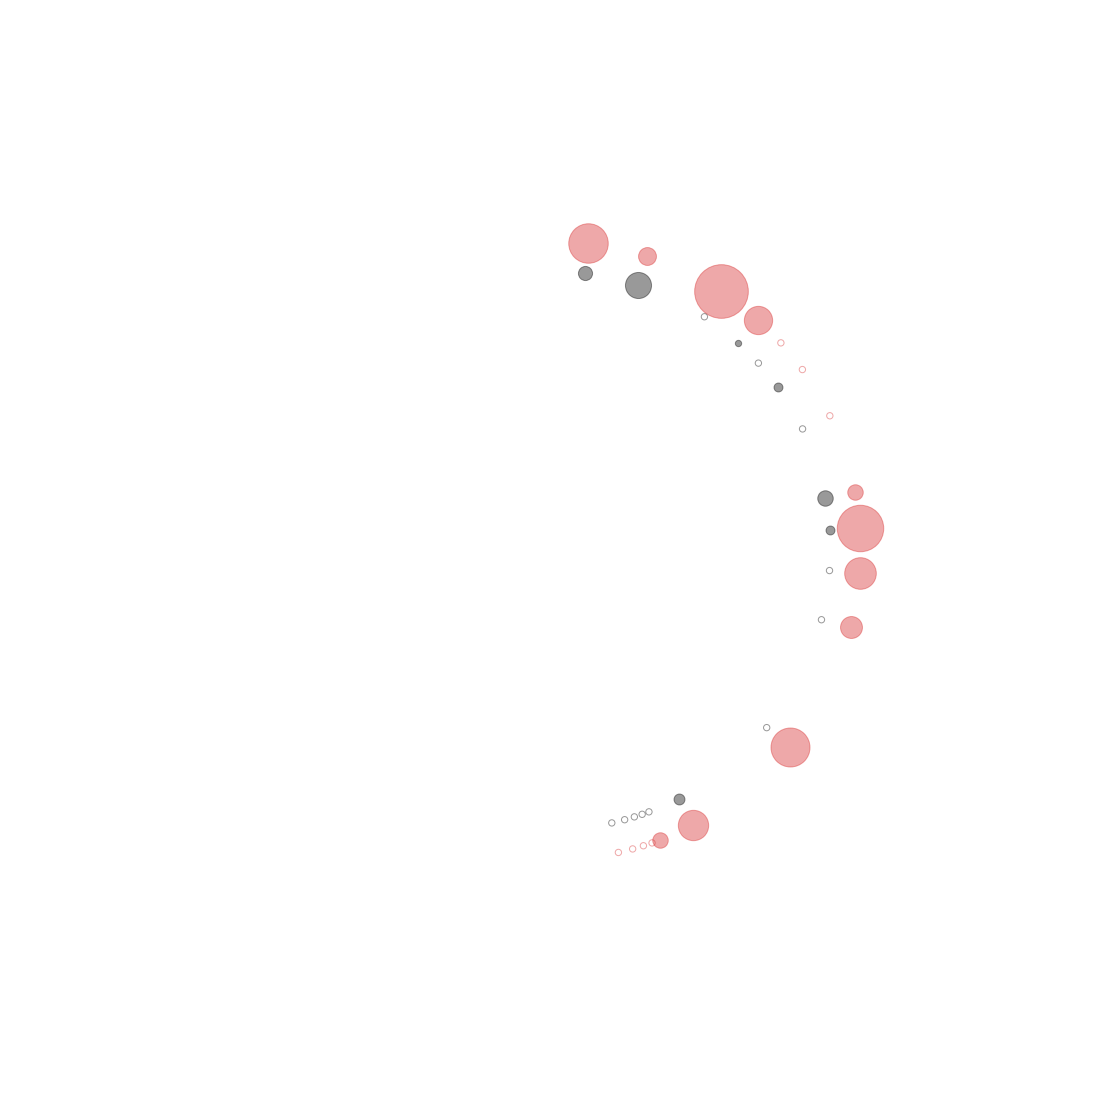

In [62]:
body_x = male_wing_viz[0]['x']
body_y = male_wing_viz[0]['y']
coordinates_black = dict()
coordinates_red = dict()
for asct in male_wing_viz:
    if asct['name'] in male_nodes[male_nodes['id_old']==1].name.values:
        # male_rots_for_organs[asct['name']] = -round(np.arctan((asct['x']-body_x)/(body_y-asct['y']))*180/np.pi, 3)
        coordinates_red[asct['name']] = (round(body_x + 13.3*(asct['x']-body_x),2), round(body_y + 13.3*(asct['y']-body_y), 2))
        coordinates_black[asct['name']] = (round(body_x + 12*(asct['x']-body_x),2), round(body_y + 12*(asct['y']-body_y), 2))

mapping = {'Respiratory System': 'lung', 'heart': 'heart', 'brain': 'brain', 'eye': 'eye', 'skin': 'skin', 'thoracic thymus': 'thymus', 'lymph node': 'lymph node', 
           'spleen': 'spleen', 'liver': 'liver', 'Pancreas': 'pancreas', 'Small Intestine': 'small intestine', 'large intestine': 'large intestine', 'kidney': 'kidney', 
           'urinary bladder': 'urinary bladder', 'ureter': 'ureter', 'prostate gland': 'prostate gland', 'ovary': 'ovary', 'Fallopian tube':'fallopian_tube', 
           'Uterus': 'uterus', 'Placenta': 'placenta', 'knee': 'knee', 'Bone marrow': 'bone marrow'}

plt.figure(frameon=False, figsize=(20,20))
plt.axes().set_aspect('equal')
plt.axis('off')
plt.xlim(0,1720)
plt.ylim(-1720,0)
for organ in coordinates_black.keys():
    size_scale = 40
    if mapping[organ] in match_vess.keys():
        red_diam = nomatch_vess[mapping[organ]]
        if red_diam:
            plt.scatter([coordinates_red[organ][0]], [-coordinates_red[organ][1]], s=red_diam*size_scale, c='tab:red', alpha=0.4)            
        else: 
            plt.scatter([coordinates_red[organ][0]], [-coordinates_red[organ][1]], s=1*size_scale, facecolors='none', edgecolors='tab:red', alpha=0.4) 
            
        black_diam = match_vess[mapping[organ]]
        if black_diam:
            plt.scatter([coordinates_black[organ][0]], [-coordinates_black[organ][1]], s=black_diam*size_scale, c='black', alpha=0.4)
        else:
            plt.scatter([coordinates_black[organ][0]], [-coordinates_black[organ][1]], s=1*size_scale,  facecolors='none', edgecolors='black', alpha=0.4)
        
    else:
        plt.scatter([coordinates_red[organ][0]], [-coordinates_red[organ][1]], s=1*size_scale, facecolors='none', edgecolors='tab:red', alpha=0.4)
        plt.scatter([coordinates_black[organ][0]], [-coordinates_black[organ][1]], s=1*size_scale,  facecolors='none', edgecolors='black', alpha=0.4)
    
plt.savefig(f'male_bubbles_v12.svg', bbox_inches='tight', pad_inches=0)
   
plt.show()

In [63]:
with open('female_wing_viz_v12.json', encoding='utf8') as json_file:
    viz = json.load(json_file)

In [64]:
female_wing_viz = viz['data'][0]['values']

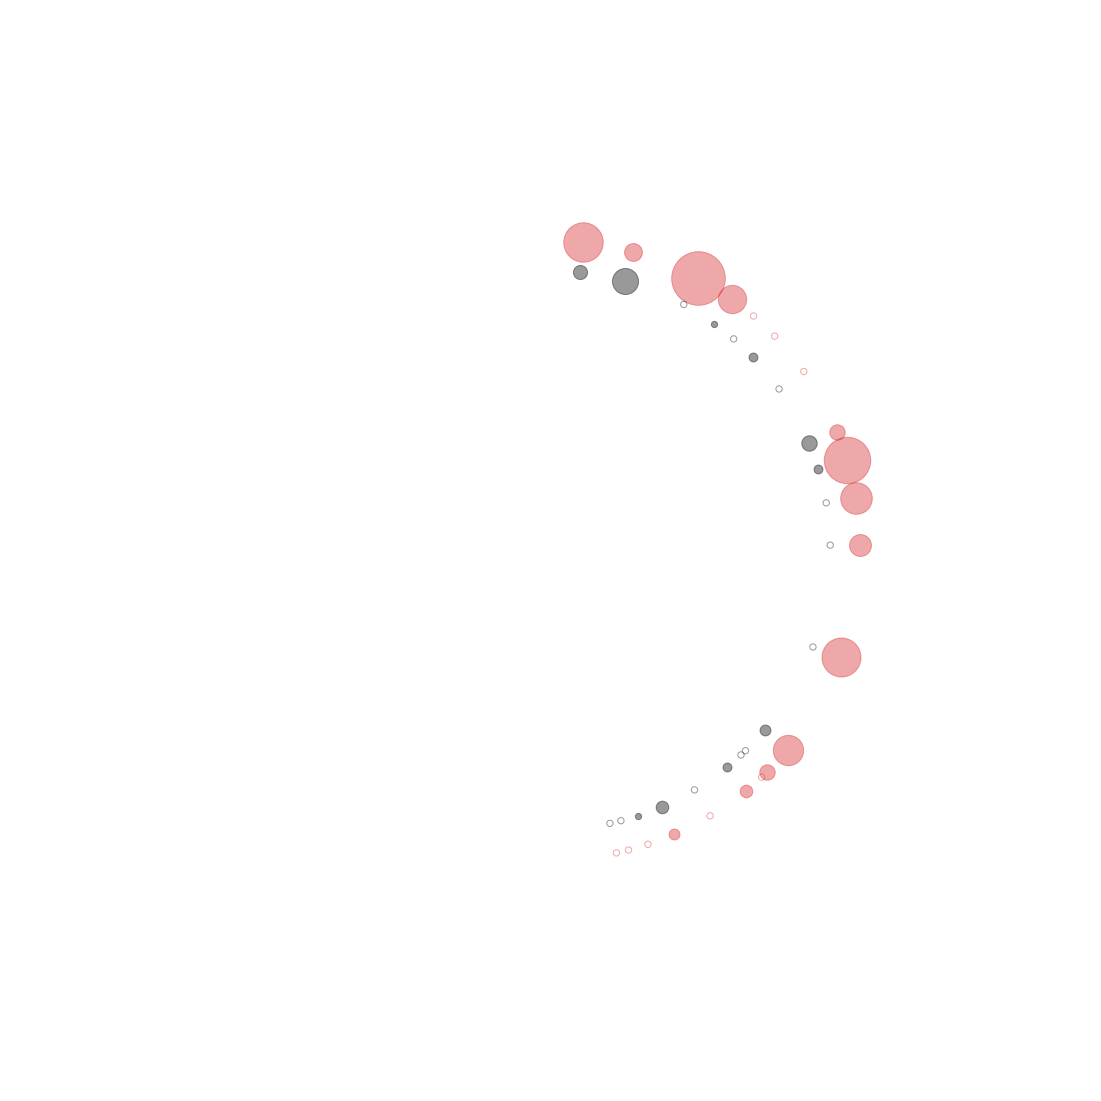

In [66]:
body_x = female_wing_viz[0]['x']
body_y = female_wing_viz[0]['y']
coordinates_black = dict()
coordinates_red = dict()
for asct in female_wing_viz:
    if asct['name'] in fem_nodes[fem_nodes['id_old']==1].name.values:
        # male_rots_for_organs[asct['name']] = -round(np.arctan((asct['x']-body_x)/(body_y-asct['y']))*180/np.pi, 3)
        coordinates_red[asct['name']] = (round(body_x + 13.3*(asct['x']-body_x),2), round(body_y + 13.3*(asct['y']-body_y), 2))
        coordinates_black[asct['name']] = (round(body_x + 12*(asct['x']-body_x),2), round(body_y + 12*(asct['y']-body_y), 2))

mapping = {'Respiratory System': 'lung', 'heart': 'heart', 'brain': 'brain', 'eye': 'eye', 'skin': 'skin', 'thoracic thymus': 'thymus', 'lymph node': 'lymph node', 
           'spleen': 'spleen', 'liver': 'liver', 'Pancreas': 'pancreas', 'Small Intestine': 'small intestine', 'large intestine': 'large intestine', 'kidney': 'kidney', 
           'urinary bladder': 'urinary bladder', 'ureter': 'ureter', 'prostate gland': 'prostate gland', 'ovary': 'ovary', 'Fallopian tube':'fallopian_tube', 
           'Uterus': 'uterus', 'Placenta': 'placenta', 'knee': 'knee', 'Bone marrow': 'bone marrow'}

plt.figure(frameon=False, figsize=(20,20))
plt.axes().set_aspect('equal')
plt.axis('off')
plt.xlim(0,1720)
plt.ylim(-1720,0)
for organ in coordinates_black.keys():
    size_scale = 40
    if mapping[organ] in match_vess.keys():
        red_diam = nomatch_vess[mapping[organ]]
        if red_diam:
            plt.scatter([coordinates_red[organ][0]], [-coordinates_red[organ][1]], s=red_diam*size_scale, c='tab:red', alpha=0.4)            
        else: 
            plt.scatter([coordinates_red[organ][0]], [-coordinates_red[organ][1]], s=1*size_scale, facecolors='none', edgecolors='tab:red', alpha=0.4) 
            
        black_diam = match_vess[mapping[organ]]
        if black_diam:
            plt.scatter([coordinates_black[organ][0]], [-coordinates_black[organ][1]], s=black_diam*size_scale, c='black', alpha=0.4)
        else:
            plt.scatter([coordinates_black[organ][0]], [-coordinates_black[organ][1]], s=1*size_scale,  facecolors='none', edgecolors='black', alpha=0.4)
        
    else:
        plt.scatter([coordinates_red[organ][0]], [-coordinates_red[organ][1]], s=1*size_scale, facecolors='none', edgecolors='tab:red', alpha=0.4)
        plt.scatter([coordinates_black[organ][0]], [-coordinates_black[organ][1]], s=1*size_scale,  facecolors='none', edgecolors='black', alpha=0.4)
    
plt.savefig(f'female_bubbles_v12.svg', bbox_inches='tight', pad_inches=0)
   
plt.show()

In [67]:
coordinates_black

{'Respiratory System': (905.87, 420.28),
 'heart': (977.91, 433.91),
 'brain': (1070.36, 471.15),
 'eye': (1118.9, 501.63),
 'skin': (1149.33, 525.71),
 'thoracic thymus': (1179.54, 554.46),
 'lymph node': (1221.11, 604.94),
 'spleen': (1268.52, 690.97),
 'liver': (1283.06, 731.63),
 'Pancreas': (1295.71, 785.09),
 'Small Intestine': (1302.03, 851.96),
 'large intestine': (1274.73, 1013.14),
 'kidney': (1198.17, 1144.77),
 'urinary bladder': (1167.95, 1177.21),
 'ureter': (1160.9, 1183.91),
 'ovary': (1138.93, 1203.01),
 'Fallopian tube': (1087.33, 1239.18),
 'Uterus': (1035.94, 1265.59),
 'Placenta': (998.63, 1279.81),
 'knee': (970.94, 1287.96),
 'Bone marrow': (953.58, 1292.09)}

In [68]:
coordinates_red

{'Respiratory System': (910.84, 372.65),
 'heart': (990.68, 387.75),
 'brain': (1093.15, 429.02),
 'eye': (1146.95, 462.81),
 'skin': (1180.67, 489.5),
 'thoracic thymus': (1214.15, 521.36),
 'lymph node': (1260.23, 577.31),
 'spleen': (1312.77, 672.66),
 'liver': (1328.89, 717.72),
 'Pancreas': (1342.91, 776.97),
 'Small Intestine': (1349.92, 851.09),
 'large intestine': (1319.66, 1029.73),
 'kidney': (1234.81, 1175.63),
 'urinary bladder': (1201.31, 1211.58),
 'ureter': (1193.5, 1219.0),
 'ovary': (1169.15, 1240.17),
 'Fallopian tube': (1111.96, 1280.26),
 'Uterus': (1055.0, 1309.53),
 'Placenta': (1013.65, 1325.29),
 'knee': (982.96, 1334.32),
 'Bone marrow': (963.72, 1338.9)}

# Vascular network 

In [69]:
matching_nodes = vasc_data[(vasc_data['is_in_organ_table']==1)& (vasc_data.BodyPart!='testis')]

In [70]:
vasc_edges = pd.read_excel('./Blood_Vasculature_v1.2_EXTENDED.xlsx', sheet_name='Vessel')[['BranchesFrom', 'Vessel', 'VesselType']]
vasc_edges

,BranchesFrom,Vessel,VesselType
0,left atrium,left atrium,heart chamber
1,left atrium,left inferior pulmonary vein,vein
2,left atrium,left superior pulmonary vein,vein
3,left atrium,pulmonary vein,vein
4,pulmonary vein,segmental pulmonary vein,vein
...,...,...,...
956,right interlobar pulmonary artery,posterior segmental artery of right lung,artery
957,right interlobar pulmonary artery,superior segmental artery of right lung,artery
958,right pulmonary artery,truncus anterior of right pulmonary artery,artery
959,truncus anterior of right pulmonary artery,anterior segmental artery of right lung,artery


In [71]:
matching_nodes

,BodyPart,BodyPartID,Vessel,VesselLabel,VesselID,VesselType,VesselSubType,PortalSystem,FTU,is_in_organ_table,not_in_organ_table,#vessels
154,eye,UBERON:0000970,capillary layer of choroid,capillary layer of choroid,UBERON:0005336,capillary,fenestrated,NaN,NaN,1,0,1
336,heart,UBERON:0000948,atrioventicular nodal artery,Atrioventricular node branch of right coronary...,FMA:3851,artery,NaN,NaN,NaN,1,0,1
337,heart,UBERON:0000948,conus artery,Conus artery,FMA:15736,artery,NaN,NaN,NaN,1,0,1
338,heart,UBERON:0000948,coronary sinus,coronary sinus,UBERON:0005438,sinus,NaN,NaN,NaN,1,0,1
339,heart,UBERON:0000948,diagonal branch of left anterior descending ar...,Diagonal branch of anterior descending branch ...,FMA:3860,artery,NaN,NaN,NaN,1,0,1
342,heart,UBERON:0000948,great cardiac vein,great vein of heart,UBERON:0006958,vein,NaN,NaN,NaN,1,0,1
343,heart,UBERON:0000948,left anterior descending artery,Anterior interventricular branch of left coron...,FMA:3862,artery,NaN,NaN,NaN,1,0,1
346,heart,UBERON:0000948,left marginal vein,Left marginal vein,FMA:4708,vein,NaN,NaN,NaN,1,0,1
347,heart,UBERON:0000948,middle cardiac vein,middle cardiac vein,UBERON:0009687,vein,NaN,NaN,NaN,1,0,1
351,heart,UBERON:0000948,posterior descending artery,Posterior interventricular branch of right cor...,FMA:3840,artery,NaN,NaN,NaN,1,0,1


In [72]:
vasc_edges = vasc_edges.rename(columns={'BranchesFrom':'source', 'Vessel': 'target'})
# vasc_edges.to_excel('vasc_edgelist.xlsx')

In [73]:
#Removal of the self-loops
vasc_edges = vasc_edges[vasc_edges.source!=vasc_edges.target]

In [74]:
vasc_graph = nx.from_pandas_edgelist(vasc_edges)

In [75]:
layout_pos_full = nx.drawing.nx_pydot.graphviz_layout(vasc_graph)

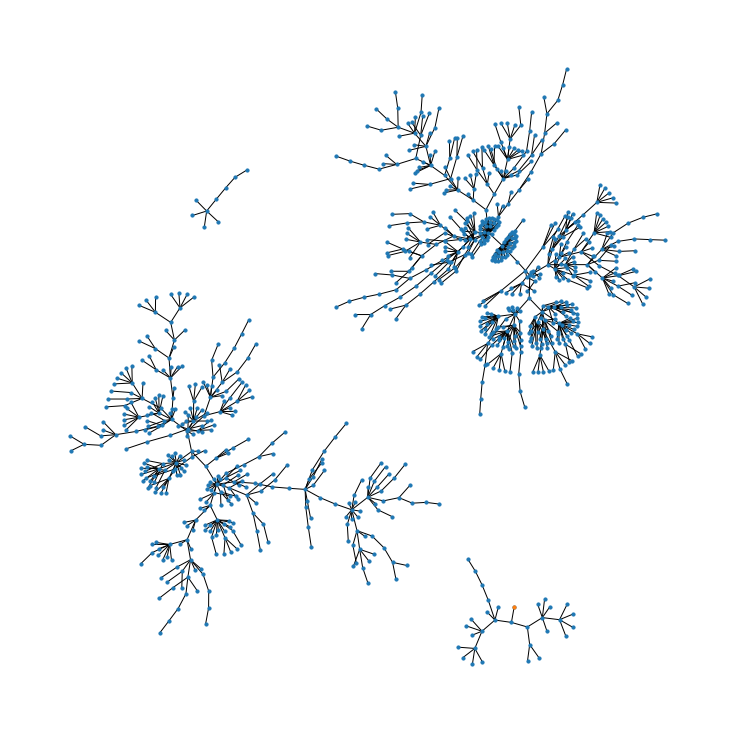

In [76]:
plt.figure(figsize=(10,10))
nx.draw(vasc_graph, pos=layout_pos_full, node_size=10)
nx.draw_networkx_nodes(vasc_graph, layout_pos_full, nodelist=['right ventricle'], node_size=10, node_color='tab:orange')
plt.show()

### Construction of the pruned graph

The graph has to be pruned at the matching nodes

We start with the layer of matching nodes, and then in each iteration, we get the parent nodes (vessels), i.e. we are moving towards the core of the network in layers. 

In [77]:
layer = vasc_edges[vasc_edges.target.isin(matching_nodes.Vessel)]
layers = [layer]
indices = list(layer.index)
while len(layer):
    layer = vasc_edges[(vasc_edges.target.isin(layer.source)) & (~vasc_edges.index.isin(indices))]
    layers += [layer]
    indices += list(layer.index)

In [78]:
pruned_vasc_edges = vasc_edges[vasc_edges.index.isin(indices)]

In [79]:
len(pruned_vasc_edges)

77

Nodes of the pruned network:

In [80]:
vasc_data[vasc_data['Vessel'].isin(set(pruned_vasc_edges[['source', 'target']].values.flatten()))]

,BodyPart,BodyPartID,Vessel,VesselLabel,VesselID,VesselType,VesselSubType,PortalSystem,FTU,is_in_organ_table,not_in_organ_table,#vessels
0,abdominal cavity,UBERON:0003684,abdominal aorta,abdominal aorta,UBERON:0001516,artery,NaN,NaN,NaN,0,1,1
1,abdominal cavity,UBERON:0003684,celiac artery,celiac artery,UBERON:0001640,artery,NaN,NaN,NaN,0,1,1
6,abdominal cavity;thoracic cavity,UBERON:0003684;UBERON:0002224,aorta,aorta,UBERON:0000947,artery,NaN,NaN,NaN,0,1,1
7,abdominal cavity;thoracic cavity,UBERON:0003684;UBERON:0002224,inferior vena cava,posterior vena cava,UBERON:0001072,vein,NaN,NaN,NaN,0,1,1
8,abdominal wall,UBERON:0003697,inferior epigastric artery,inferior epigastric artery,UBERON:0001354,artery,NaN,NaN,NaN,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
946,uterus,UBERON:0000995,arcuate artery of uterus,helicine branch of uterine artery,UBERON:0015173,artery,NaN,NaN,NaN,1,0,1
947,uterus,UBERON:0000995,artery of round ligament of uterus,Artery of round ligament of uterus,FMA:70195,artery,NaN,NaN,NaN,1,0,1
949,uterus,UBERON:0000995,uterine artery,uterine artery,UBERON:0002493,artery,NaN,NaN,NaN,1,0,1
951,uterus,UBERON:0000995,uterine vein,Uterine vein,FMA:18896,vein,NaN,NaN,NaN,0,1,1


In [81]:
vasc_data[vasc_data['Vessel'].isin(set(pruned_vasc_edges[['source', 'target']].values.flatten()))][['BodyPart', 'Vessel', 'VesselID', 'VesselType']].to_excel('nodes_of_vascular_network_v12.xlsx')

In [82]:
pruned_vasc_edges.to_excel('vasc_edgelist_v12.xlsx')
vasc_edges.to_excel('vasc_edgelist_all_v12.xlsx')

In [83]:
pruned_vasc_graph = nx.from_pandas_edgelist(pruned_vasc_edges)

In [84]:
len(pruned_vasc_graph)

80

In [85]:
pruned_vasc_graph = nx.induced_subgraph(vasc_graph, set(pruned_vasc_graph.nodes).union(set(matching_nodes.Vessel.values)))

In [86]:
len(pruned_vasc_graph)

81

Note that the network is not connected, hence we have to add manually the 'heart' node and connect it to the components

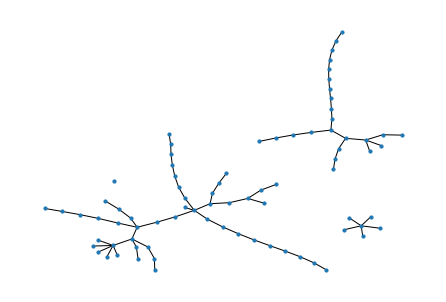

In [89]:
layout_pos = nx.drawing.nx_pydot.graphviz_layout(pruned_vasc_graph)
nx.draw(pruned_vasc_graph, pos=layout_pos, node_size=10)

### Get the coordinates from the Vega visualization 

In [102]:
with open('female_wing_viz_v12.json', encoding='utf8') as json_file:
    viz = json.load(json_file)

In [103]:
female_viz = viz['data'][0]['values']

Merge of heart & heart chamber, thyroid gland & lung and rename pelvis to placenta

In [106]:
organ_mapping = {'eye': 'eye', 'heart': 'heart', 'heart chamber': 'heart', 'kidney': 'kidney', 
                 'liver': 'liver', 'lung': 'lung', 'ovary': 'ovary', 'pelvis': 'placenta', 'spleen': 'spleen', 
                 'thymus': 'thymus', 'thyroid gland': 'lung', 'uterus': 'uterus'}

In [107]:
matching_nodes['organ'] = matching_nodes['BodyPart'].apply(lambda x: organ_mapping[x])

C:\Users\slapj\AppData\Local\Temp\ipykernel_2412\3296384991.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matching_nodes['organ'] = matching_nodes['BodyPart'].apply(lambda x: organ_mapping[x])


Get the coordinates for the vessels

## Full graph

In [112]:
def get_coordinates_4_vessels(visualization, graph=pruned_vasc_graph):
    name = []
    name_in_vasc = []
    coords=[]
    organs = []
    for node in visualization:
        if node['ontology_id'] in matching_nodes['VesselID'].values: #if the node is in the vascular data 
            if node['organ']==matching_nodes[matching_nodes['VesselID']==node['ontology_id']]['organ'].values[0]: # and if the organs match
                name += [node['name']]
                name_in_vasc += [matching_nodes[matching_nodes['VesselID']==node['ontology_id']]['Vessel'].values[0]]
                coords += [np.array([node['x'], -node['y']])]
                organs += [node['organ']]

    for node in graph:
        if node not in name_in_vasc:
            name += [node]
            name_in_vasc += [node]
            coords += [np.nan]
            organs += [np.nan]

    art_data = pd.DataFrame.from_dict({'name': name, 'name_in_vasc': name_in_vasc,
                                       'organ': organs, 'coords': coords})
    
    art_data = art_data.drop_duplicates(subset=['name_in_vasc', 'organ']).reset_index(drop=True) 
    
    art_data = art_data[art_data.name_in_vasc.isin(graph.nodes())]
    
    return art_data

In [113]:
coords = get_coordinates_4_vessels(female_viz)

In [114]:
coords.head()

,name,name_in_vasc,organ,coords
0,Pulmonary vein,pulmonary vein,lung,"[874.2494487937033, -750.3960781218569]"
1,right atrium,right atrium,heart,"[871.4722646782019, -787.2143556459125]"
2,sinoatrial nodal artery,sinoatrial nodal artery,heart,"[875.2222990239743, -750.5269526576557]"
3,atrioventicular nodal artery,atrioventicular nodal artery,heart,"[881.2066945628267, -751.5272265141458]"
4,coronary sinus,coronary sinus,heart,"[881.9068865456633, -751.6664650079676]"


In [115]:
len(coords)

81

In [116]:
relabel_mapping = coords['name_in_vasc'].to_dict()
relabel_mapping = {v: k for k, v in relabel_mapping.items()}

In [117]:
renamed_pruned_vasc = nx.relabel_nodes(pruned_vasc_graph, relabel_mapping)

In [118]:
pos = coords['coords'].dropna().to_dict()

In [119]:
pos2 = nx.spring_layout(renamed_pruned_vasc, pos=pos, fixed=list(pos.keys()), iterations=1000)

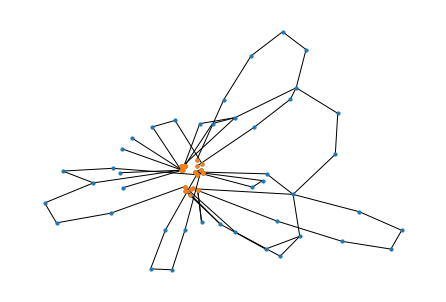

In [120]:
nx.draw(renamed_pruned_vasc, pos2, node_size=10)
nx.draw_networkx_nodes(renamed_pruned_vasc, pos2, nodelist=list(pos.keys()), node_color='tab:orange', node_size=10)
# plt.savefig('small_network.png', dpi=300)
plt.show()

In [121]:
connected_comps = [pruned_vasc_graph.subgraph(c).copy() for c in nx.connected_components(pruned_vasc_graph)]

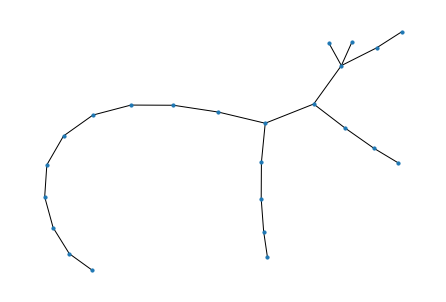

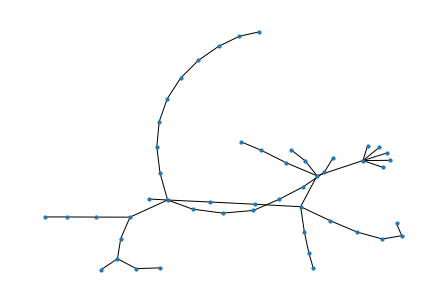

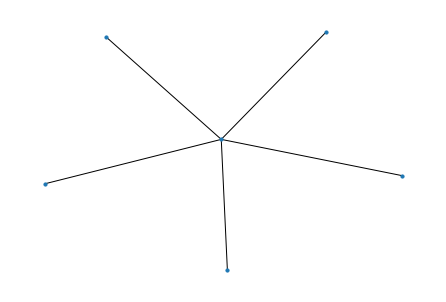

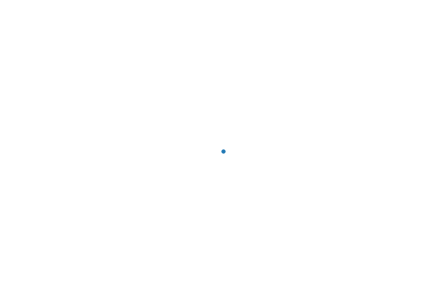

In [122]:
for comp in connected_comps:
    nx.draw(comp, node_size=10)
    plt.show()

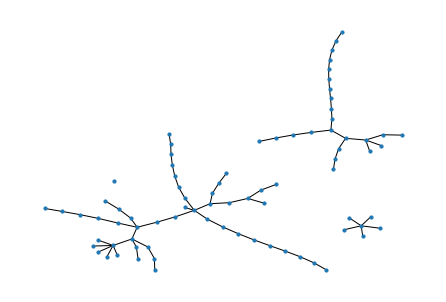

In [123]:
nx.draw(pruned_vasc_graph, pos=layout_pos, node_size=10)
plt.show()

In [124]:
leaves_of_pruned = [node for node in pruned_vasc_graph if nx.degree(pruned_vasc_graph, node)<=1]

In [125]:
len(leaves_of_pruned)

27

In [126]:
matching_not_leaf = [node for node in matching_nodes.Vessel.values if node not in leaves_of_pruned]

In [127]:
matching_leaf = [node for node in matching_nodes.Vessel.values if node in leaves_of_pruned]

In [128]:
len(matching_not_leaf)+len(matching_leaf)

42

In [129]:
len(matching_nodes)

42

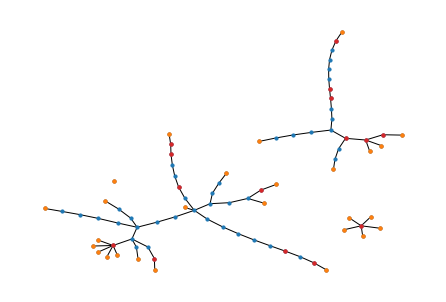

In [130]:
nx.draw(pruned_vasc_graph, pos=layout_pos, node_size=10)
nx.draw_networkx_nodes(pruned_vasc_graph, layout_pos,
                       nodelist=matching_not_leaf, 
                       node_color='tab:red', node_size=12)
nx.draw_networkx_nodes(pruned_vasc_graph, layout_pos,
                       nodelist=matching_leaf, 
                       node_color='tab:orange', node_size=12)
plt.show()

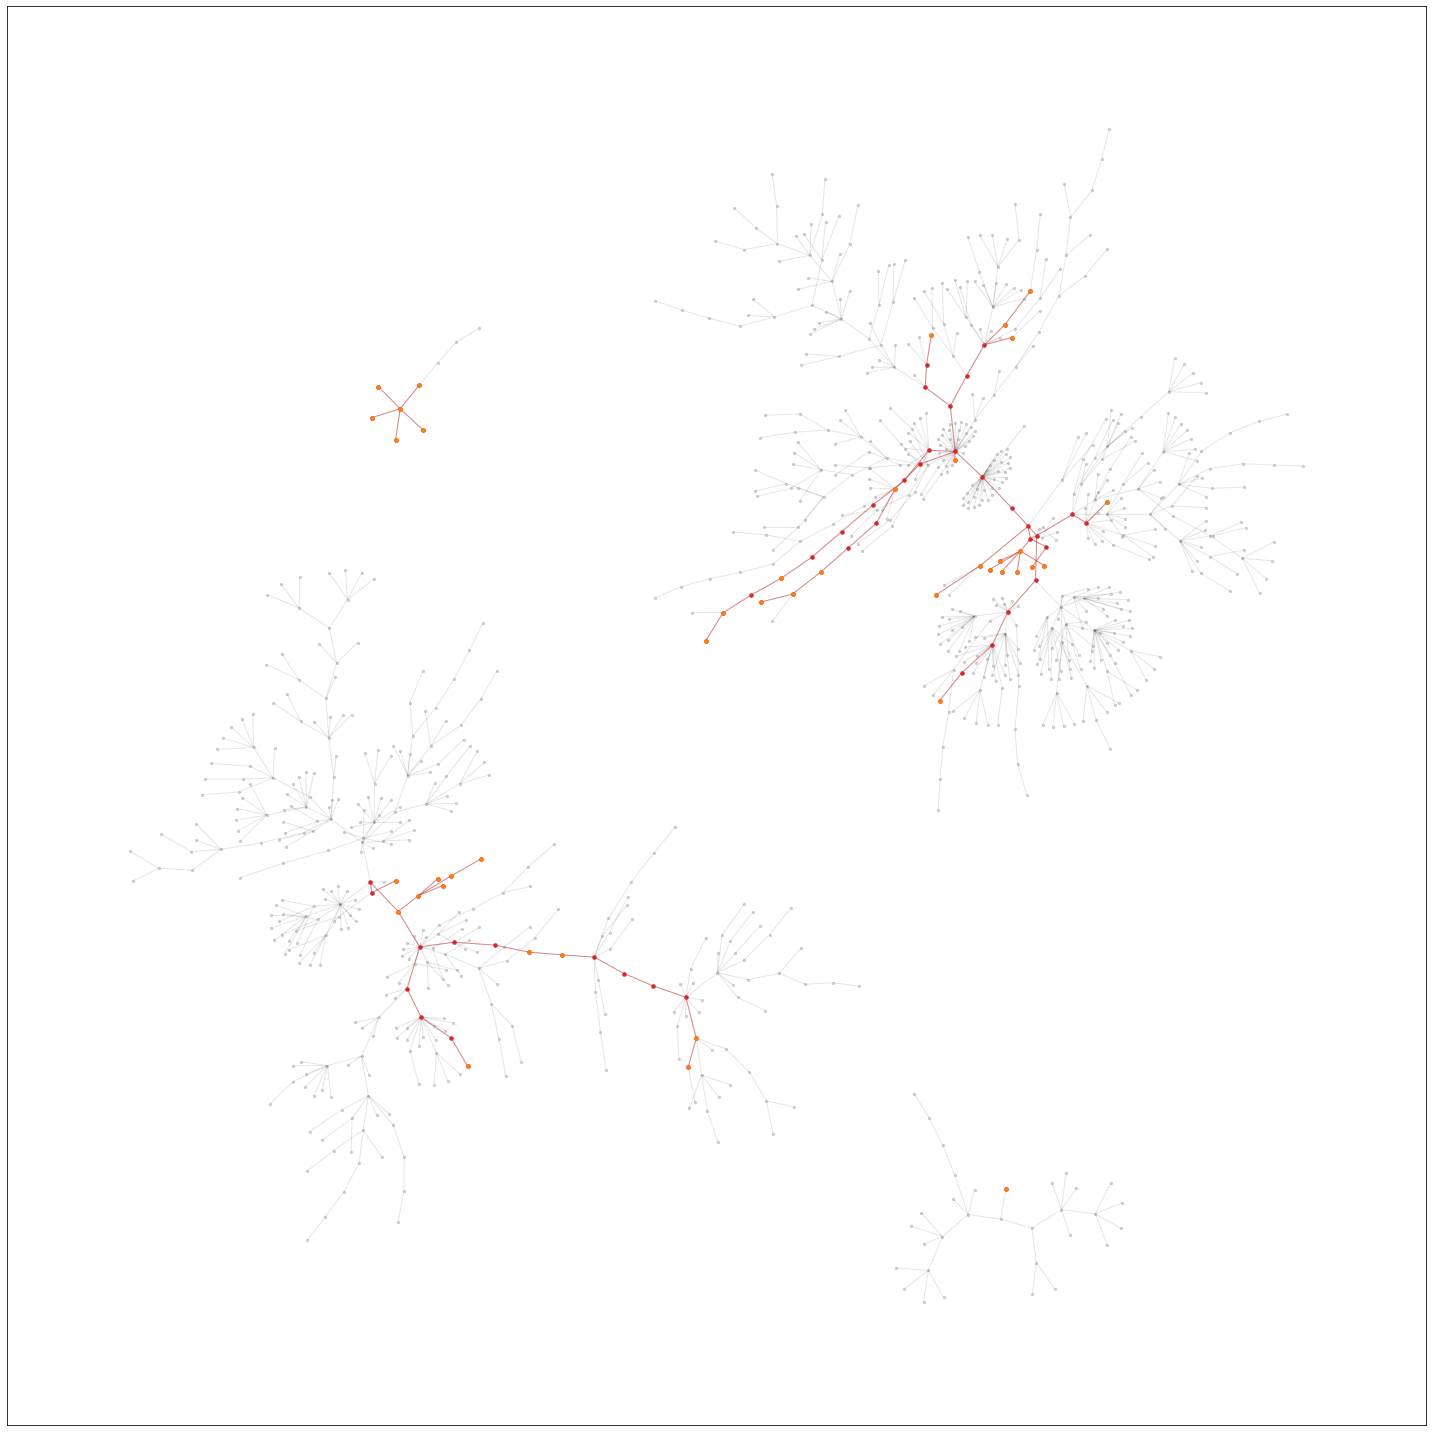

In [131]:
plt.figure(figsize=(20,20))
nx.draw_networkx_nodes(vasc_graph, pos=layout_pos_full, node_size=5, node_color='tab:grey', alpha=0.3)
nx.draw_networkx_edges(vasc_graph, pos=layout_pos_full, alpha=0.1)
nx.draw_networkx_edges(pruned_vasc_graph, pos=layout_pos_full, alpha=0.5, edge_color='tab:red')
nx.draw_networkx_nodes(pruned_vasc_graph, layout_pos_full,
                       nodelist=pruned_vasc_graph.nodes, 
                       node_color='tab:red', node_size=12)
nx.draw_networkx_nodes(pruned_vasc_graph, layout_pos_full,
                       nodelist=matching_not_leaf, 
                       node_color='tab:orange', node_size=12)
nx.draw_networkx_nodes(pruned_vasc_graph, layout_pos_full,
                       nodelist=matching_leaf, 
                       node_color='tab:orange', node_size=12)
plt.tight_layout()
plt.savefig('vascular_v12.png', dpi=300)
plt.show()

# Connect the components of the vascular network 

In [132]:
# Load json files 
json_data_asctb_blood = {}
for filename in listdir('./asct+b/v12/'):
    if '.json' in filename:
        # print(filename)
        with open(f'./asct+b/v12/{filename}', encoding='utf8') as json_file:
            data = json.load(json_file)

        json_data_asctb_blood[filename[:-5]] = data

In [133]:
json_data_asctb_blood.keys()

dict_keys(['blood', 'blood_vasculature', 'bone_marrow', 'brain', 'eye', 'fallopian_tube', 'heart', 'kidney', 'knee', 'large_intestine', 'liver', 'lung', 'lymph_nodes', 'lymph_vasculature', 'ovary', 'pancreas', 'peripheral_nervous_system', 'placenta', 'prostate', 'skin', 'small_intestine', 'spleen', 'thymus', 'ureter', 'urinary_bladder', 'uterus'])

In [134]:
nodes, edges = combine_data(json_data_asctb_blood, remove_ctct=True, combine=False, blood=True)

blood is tree: True
blood_vasculature is tree: True
bone_marrow is tree: True
brain is tree: True
eye is tree: True
fallopian_tube is tree: True
heart is tree: True
kidney is tree: True
knee is tree: True
large_intestine is tree: True
liver is tree: True
lung is tree: True
lymph_nodes is tree: True
ovary is tree: True
pancreas is tree: True
placenta is tree: True
prostate is tree: True
skin is tree: True
small_intestine is tree: True
spleen is tree: True
thymus is tree: True
ureter is tree: True
urinary_bladder is tree: True
uterus is tree: True


In [135]:
blood_vasc_nodes = nodes['blood_vasculature']

In [136]:
blood_vasc_edges = edges['blood_vasculature']

In [137]:
blood_vasc_nodes

,id,id_old,name,type,organ,ontology_id
id,,,,,,
0,0,0,Body,AS,body,UBERON:0013702
1,1,1,blood vasculature,AS,blood_vasculature,UBERON:0004537
2,2,2,left atrium,AS,blood_vasculature,UBERON:0002079
3,3,3,left inferior pulmonary vein,AS,blood_vasculature,FMA:49913
4,4,4,left superior pulmonary vein,AS,blood_vasculature,FMA:49916
...,...,...,...,...,...,...
3869,3869,961,endothelial cell of arteriole,CT,blood_vasculature,CL:1000412
3870,3870,961,endothelial cell of arteriole,CT,blood_vasculature,CL:1000412
3871,3871,961,endothelial cell of arteriole,CT,blood_vasculature,CL:1000412


In [138]:
blood_vasc_graph = nx.from_pandas_edgelist(blood_vasc_edges)

In [139]:
blood_vasc_graph = nx.relabel_nodes(blood_vasc_graph, blood_vasc_nodes['name'].to_dict())

In [157]:
pos = nx.drawing.nx_pydot.graphviz_layout(blood_vasc_graph, root='blood vasculature')

In [158]:
[node for node in pruned_vasc_graph if node not in blood_vasc_graph]

['hepatic portal vein']

In [159]:
subgraph = nx.induced_subgraph(blood_vasc_graph, list(pruned_vasc_graph.nodes)+['blood vasculature'])

In [160]:
pos = nx.drawing.nx_pydot.graphviz_layout(subgraph, root='blood vasculature')

In [161]:
pos_of_pruned = nx.spring_layout(pruned_vasc_graph, pos=pos, fixed=pos.keys(), iterations=1000, dim=2, k=0.01/np.sqrt(len(pruned_vasc_graph)))

In [162]:
connected_comps = [pruned_vasc_graph.subgraph(c).copy() for c in nx.connected_components(pruned_vasc_graph)]

In [163]:
new_edges = [edge for edge in subgraph.edges if edge not in pruned_vasc_graph.edges]

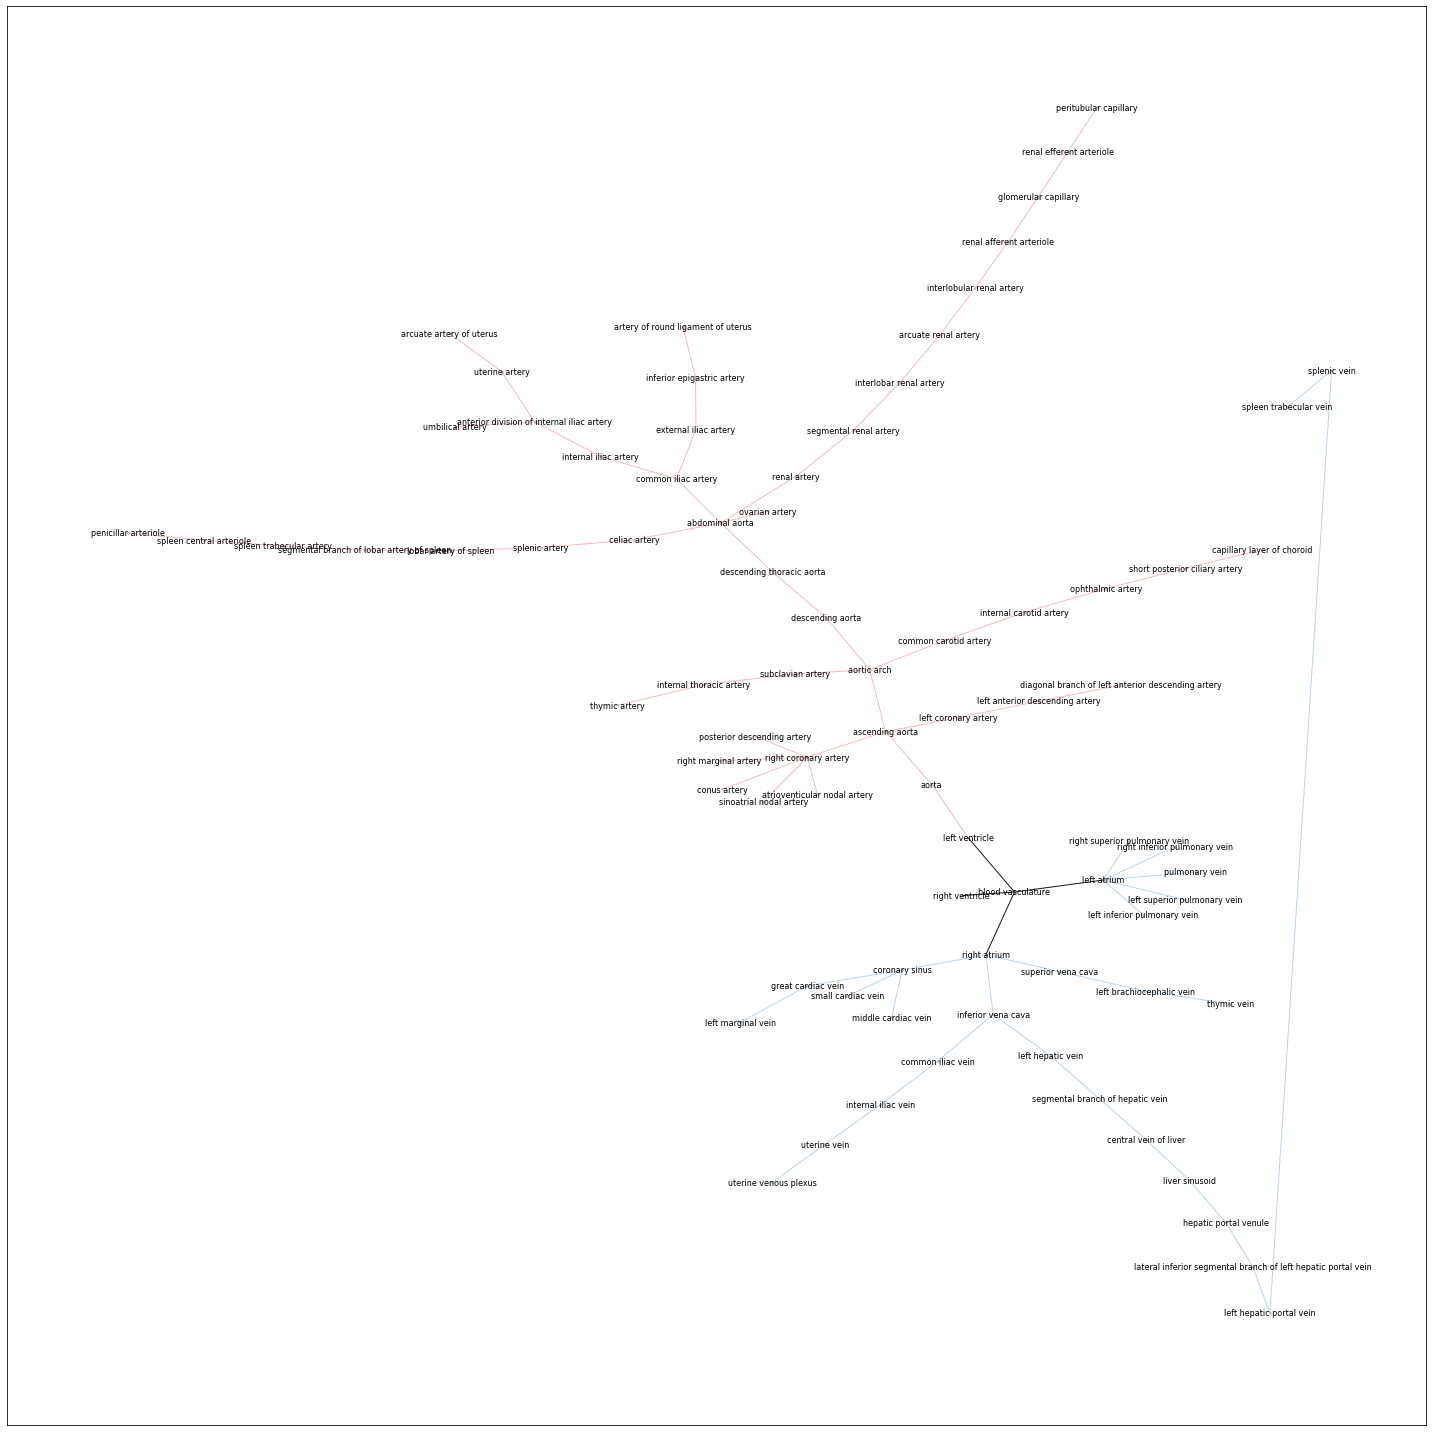

In [164]:
plt.figure(figsize=(20,20))
nx.draw_networkx_nodes(subgraph, pos=pos, node_size=5, node_color='tab:grey', alpha=0.3)
nx.draw_networkx_labels(subgraph, pos=pos, font_size=8)
nx.draw_networkx_edges(subgraph, pos=pos, edgelist=new_edges, alpha=0.9)

colors = ['tab:blue','tab:red', 'tab:blue', 'tab:red']
for idx, comp in enumerate(connected_comps):
    nx.draw_networkx_edges(comp, pos=pos_of_pruned, alpha=0.3, edge_color=colors[idx])

plt.tight_layout()
plt.savefig('completed_vascular_v12.png', dpi=350)
plt.show()

In [167]:
new_edges

[('blood vasculature', 'left atrium'),
 ('blood vasculature', 'left ventricle'),
 ('blood vasculature', 'right atrium'),
 ('blood vasculature', 'right ventricle')]

In [168]:
[edge for edge in pruned_vasc_graph.edges if edge[0] in ['hepatic portal vein']]

[]

### add edges

In [169]:
pruned_vasc_graph_comp = pruned_vasc_graph.copy()

In [170]:
pruned_vasc_graph_comp.add_edges_from([('blood vasculature', 'left atrium'),('blood vasculature', 'left ventricle'),
                                       ('blood vasculature', 'right atrium'), ('blood vasculature', 'right ventricle')])

In [180]:
veins = [node for node in pruned_vasc_graph_comp if (node not in connected_comps[1]) and (node not in connected_comps[3])]

In [181]:
arteries = [node for node in pruned_vasc_graph_comp if (node not in connected_comps[0]) and (node not in connected_comps[2])]

In [182]:
pos = nx.drawing.nx_pydot.graphviz_layout(pruned_vasc_graph_comp, root='blood vasculature')

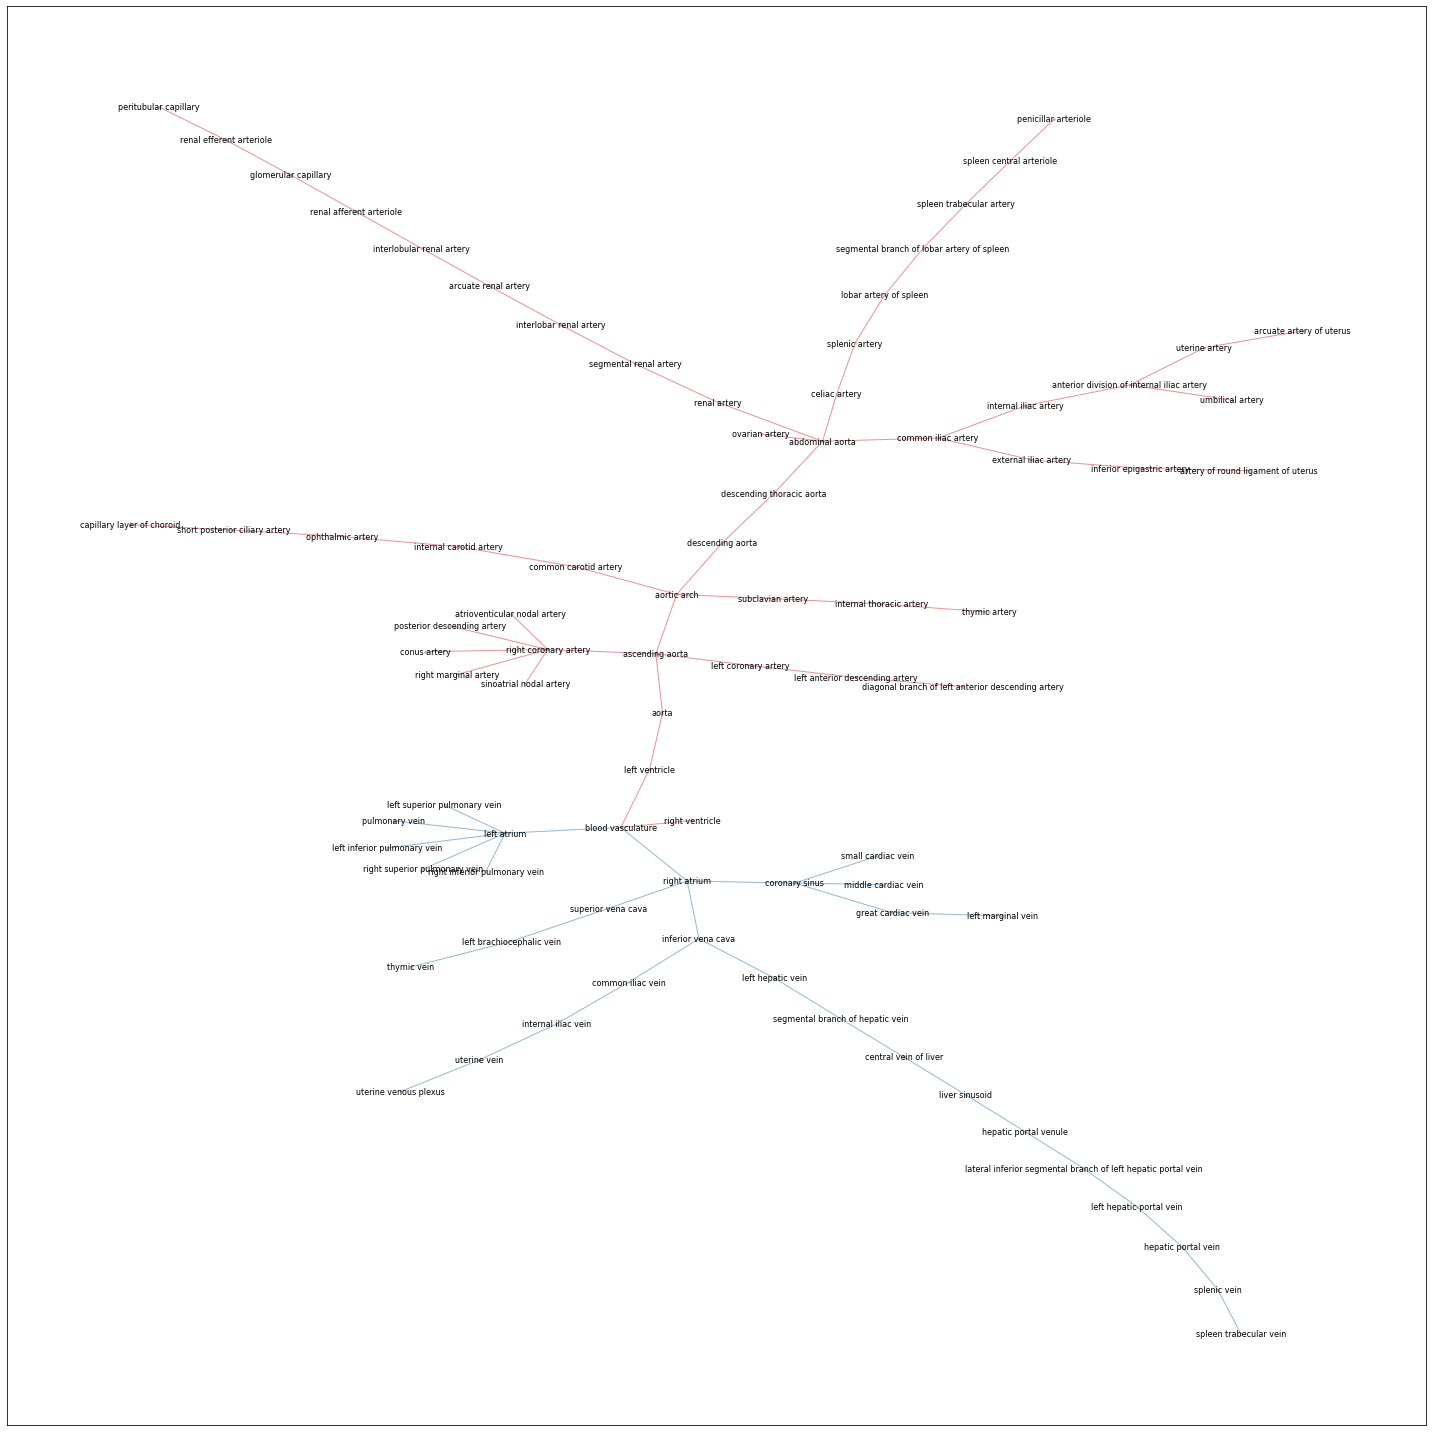

In [183]:
plt.figure(figsize=(20,20))
nx.draw_networkx_nodes(pruned_vasc_graph_comp, pos=pos, node_size=5, node_color='tab:grey', alpha=0.3)
nx.draw_networkx_labels(pruned_vasc_graph_comp, pos=pos, font_size=8)
# nx.draw_networkx_edges(subgraph, pos=pos, edgelist=new_edges, alpha=0.9)

nx.draw_networkx_edges(nx.induced_subgraph(pruned_vasc_graph_comp, veins), pos=pos, alpha=0.5, edge_color='tab:blue')
nx.draw_networkx_edges(nx.induced_subgraph(pruned_vasc_graph_comp, arteries), pos=pos, alpha=0.5, edge_color='tab:red')

plt.tight_layout()
# plt.savefig('completed_vascular.png', dpi=350)
plt.show()

# Female and male vascular network 

In [184]:
vasc_data.BodyPart.unique()

array(['abdominal cavity', 'abdominal cavity;thoracic cavity',
       'abdominal wall', 'adrenal gland', 'arm', 'brain', 'brainstem',
       'cerebellum', 'clitoris', 'diaphragm', 'ear', 'esophagus', 'eye',
       'face', 'foot', 'hand', 'head', 'heart', 'heart chamber', 'kidney',
       'large intestine', 'larynx', 'leg', 'liver', 'lung', 'neck',
       'nose', 'ovary', 'pancreas', 'pancreas;small intestine', 'pelvis',
       'penis', 'pituitary gland', 'rectum', 'scrotum', 'shoulder',
       'small intestine', 'spinal cord', 'spleen', 'stomach',
       'stomach;small intestine', 'testis', 'thoracic cavity',
       'thoracic wall', 'thymus', 'thyroid gland', 'urinary bladder',
       'uterus', 'vagina'], dtype=object)

In [185]:
female_vessels = vasc_data[vasc_data.BodyPart.isin(['clitoris', 'ovary', 'uterus', 'vagina', 'pelvis'])] #Pelvis now only contains placenta

In [186]:
male_vessels = vasc_data[vasc_data.BodyPart.isin(['penis', 'scrotum', 'testis'])]

In [187]:
pruned_vasc_graph_comp_male = nx.induced_subgraph(pruned_vasc_graph_comp, [node for node in pruned_vasc_graph_comp if node not in female_vessels.Vessel.values])

In [188]:
pruned_vasc_graph_comp_female = nx.induced_subgraph(pruned_vasc_graph_comp, [node for node in pruned_vasc_graph_comp if node not in male_vessels.Vessel.values])

In [189]:
len(pruned_vasc_graph_comp_male)

69

In [190]:
len(pruned_vasc_graph_comp_female)

82

In [191]:
len(pruned_vasc_graph_comp)

82

In [203]:
def plot_fixed_graph2(graph, viz, bundle_edges=False, draw_labels=False, filename='vasculature'):
    graphs = {'veins': nx.induced_subgraph(graph, veins), 'arteries': nx.induced_subgraph(graph, arteries)}
    coords = {'veins': get_coordinates_4_vessels(viz, graphs['veins']), 'arteries': get_coordinates_4_vessels(viz, graphs['arteries'])}
    relabel_mapping_inv = {'veins': coords['veins']['name_in_vasc'].to_dict(), 'arteries': coords['arteries']['name_in_vasc'].to_dict()}
    relabel_mapping =  {'veins': {v: k for k, v in relabel_mapping_inv['veins'].items()}, 'arteries':{v: k for k, v in relabel_mapping_inv['arteries'].items()}}
    # {'veins': , 'arteries': }
    renamed_comp = {'veins': nx.relabel_nodes(graphs['veins'], relabel_mapping['veins']), 'arteries': nx.relabel_nodes(graphs['arteries'], relabel_mapping['arteries']) } 
    
    pos = {'veins': coords['veins']['coords'].dropna().to_dict(), 'arteries': coords['arteries']['coords'].dropna().to_dict()}
    pos['veins'][relabel_mapping['veins']['blood vasculature']] = np.array([850, -860])
    pos['arteries'][relabel_mapping['arteries']['blood vasculature']] = np.array([850, -860])
    pos2 = {'veins': nx.spring_layout(renamed_comp['veins'], pos=pos['veins'], fixed=list(pos['veins'].keys()), seed=10, iterations=1000, dim=2, k=0.01/np.sqrt(len(graphs['veins']))), 
            'arteries': nx.spring_layout(renamed_comp['arteries'], pos=pos['arteries'], fixed=list(pos['arteries'].keys()), seed=10, iterations=1000, dim=2, k=0.01/np.sqrt(len(graphs['arteries'])))}
    
    if not bundle_edges:
        plt.figure(figsize=(20,20))
        plt.axes().set_aspect('equal')
        plt.xlim(0,1720)
        plt.ylim(-1720, 0)
        nx.draw(renamed_comp['veins'], pos2['veins'], node_size=10, edge_color='tab:blue', node_color='tab:blue')
        nx.draw(renamed_comp['arteries'], pos2['arteries'], node_size=10, edge_color='tab:red', node_color='tab:red')
        if draw_labels:
            nx.draw_networkx_labels(renamed_comp['veins'], pos2['veins'], labels=relabel_mapping_inv['veins'], font_size=3)
            nx.draw_networkx_labels(renamed_comp['arteries'], pos2['arteries'], labels=relabel_mapping_inv['arteries'], font_size=3)
        # nx.draw_networkx_nodes(renamed_comp, pos2, nodelist=list(pos.keys()), node_color='tab:orange', node_size=10)
        plt.tight_layout()
        plt.axis('off')
        plt.savefig(f'{filename}_v12.svg',  transparent=True)
        plt.show()
    else:
        nodes_only = {'veins': pd.DataFrame.from_dict(relabel_mapping_inv['veins'], orient='index').rename(columns={0:'name'}), 
                      'arteries': pd.DataFrame.from_dict(relabel_mapping_inv['arteries'], orient='index').rename(columns={0:'name'})}
        
        nodes = {'veins': pd.DataFrame.from_dict(pos2['veins']).T.rename(columns={0:'x', 1:'y'}).join(nodes_only['veins'])[['name', 'x', 'y']], 
                 'arteries': pd.DataFrame.from_dict(pos2['arteries']).T.rename(columns={0:'x', 1:'y'}).join(nodes_only['arteries'])[['name', 'x', 'y']]}
        
        edges = {'veins': nx.to_pandas_edgelist(renamed_comp['veins'])[['source', 'target']], 
                 'arteries': nx.to_pandas_edgelist(renamed_comp['arteries'])[['source', 'target']]}
        # hb = hammer_bundle(nodes, edges, initial_bandwidth=0.03,tension=0.9, accuracy=8000)
        hb = {'veins': hammer_bundle(nodes['veins'], edges['veins'], initial_bandwidth=.015, decay=0.8, tension=0.99, accuracy=1000), 
              'arteries': hammer_bundle(nodes['arteries'], edges['arteries'], initial_bandwidth=.015, decay=0.8, tension=0.99, accuracy=1000)}
        
        plt.figure(figsize=(20,20))
        plt.axes().set_aspect('equal')
        plt.xlim(0,1720)
        plt.ylim(-1720, 0)        
        plt.plot(hb['veins']['x'], hb['veins']['y'], color='tab:blue', alpha=0.8)
        plt.plot(hb['arteries']['x'], hb['arteries']['y'], color='tab:red', alpha=0.8)
        plt.tight_layout()
        plt.axis('off')
        plt.savefig(f'{filename}_bundled_v12.svg', pad_inches=0.0)
        plt.show()

In [204]:
with open('female_wing_viz_v12.json', encoding='utf8') as json_file:
    viz = json.load(json_file)

In [205]:
female_wing_viz = viz['data'][0]['values']

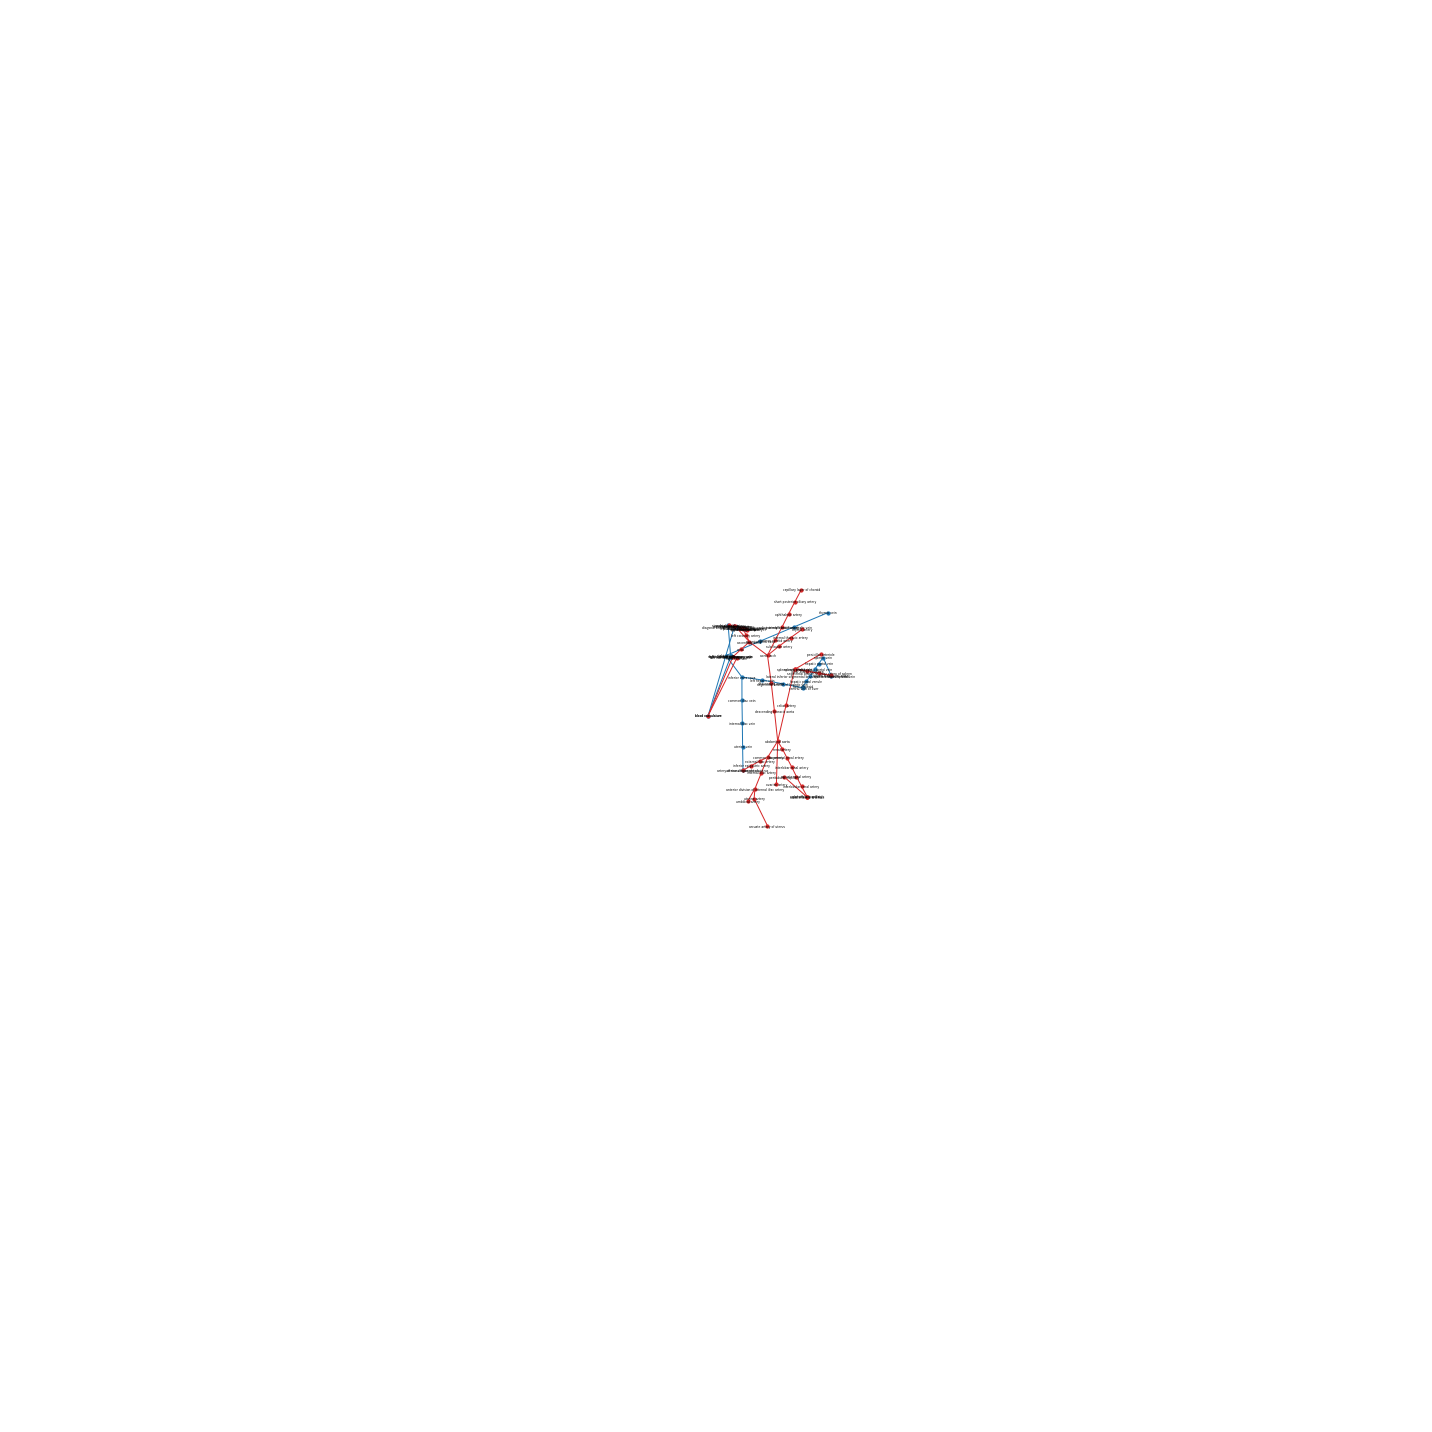

In [206]:
plot_fixed_graph2(pruned_vasc_graph_comp_female, female_wing_viz, draw_labels=True, filename='female_wing')

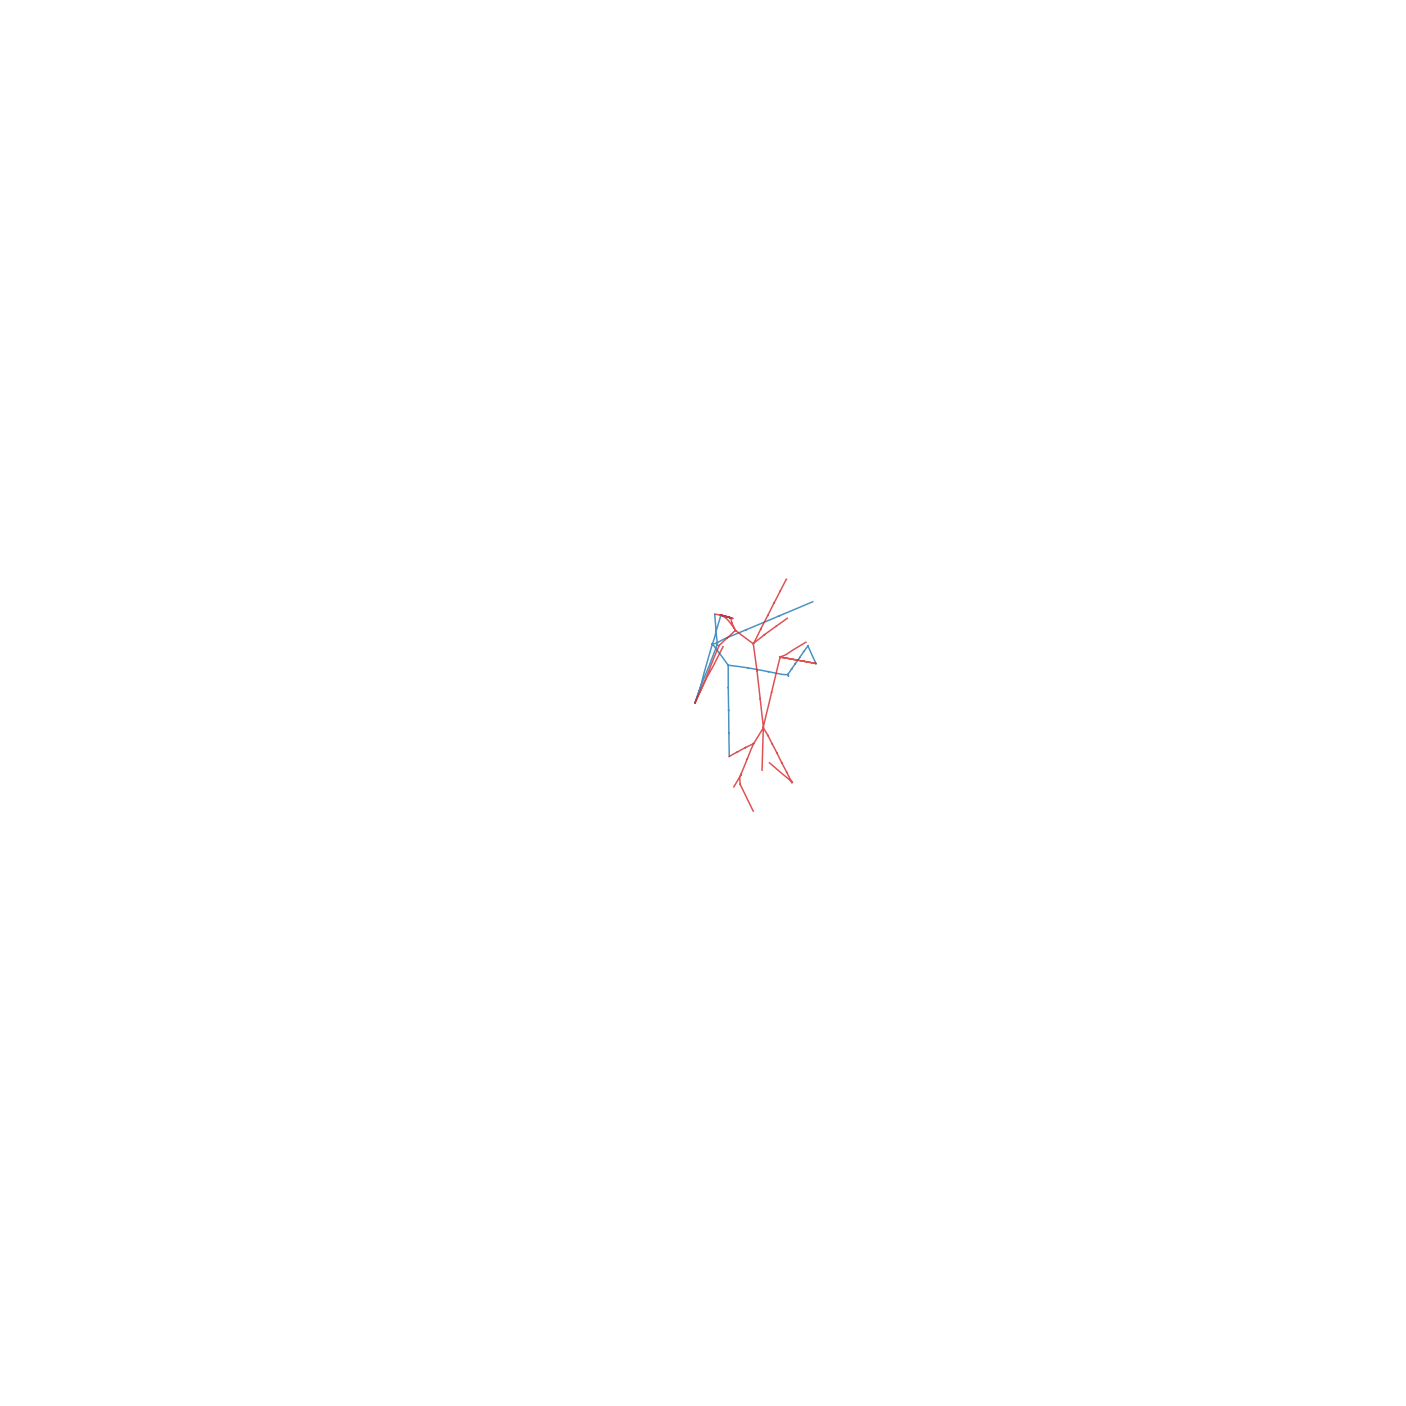

In [207]:
plot_fixed_graph2(pruned_vasc_graph_comp_female, female_wing_viz, bundle_edges=True, filename='female_wing')

In [208]:
with open('male_wing_viz_v12.json', encoding='utf8') as json_file:
    viz = json.load(json_file)

In [209]:
male_wing_viz = viz['data'][0]['values']

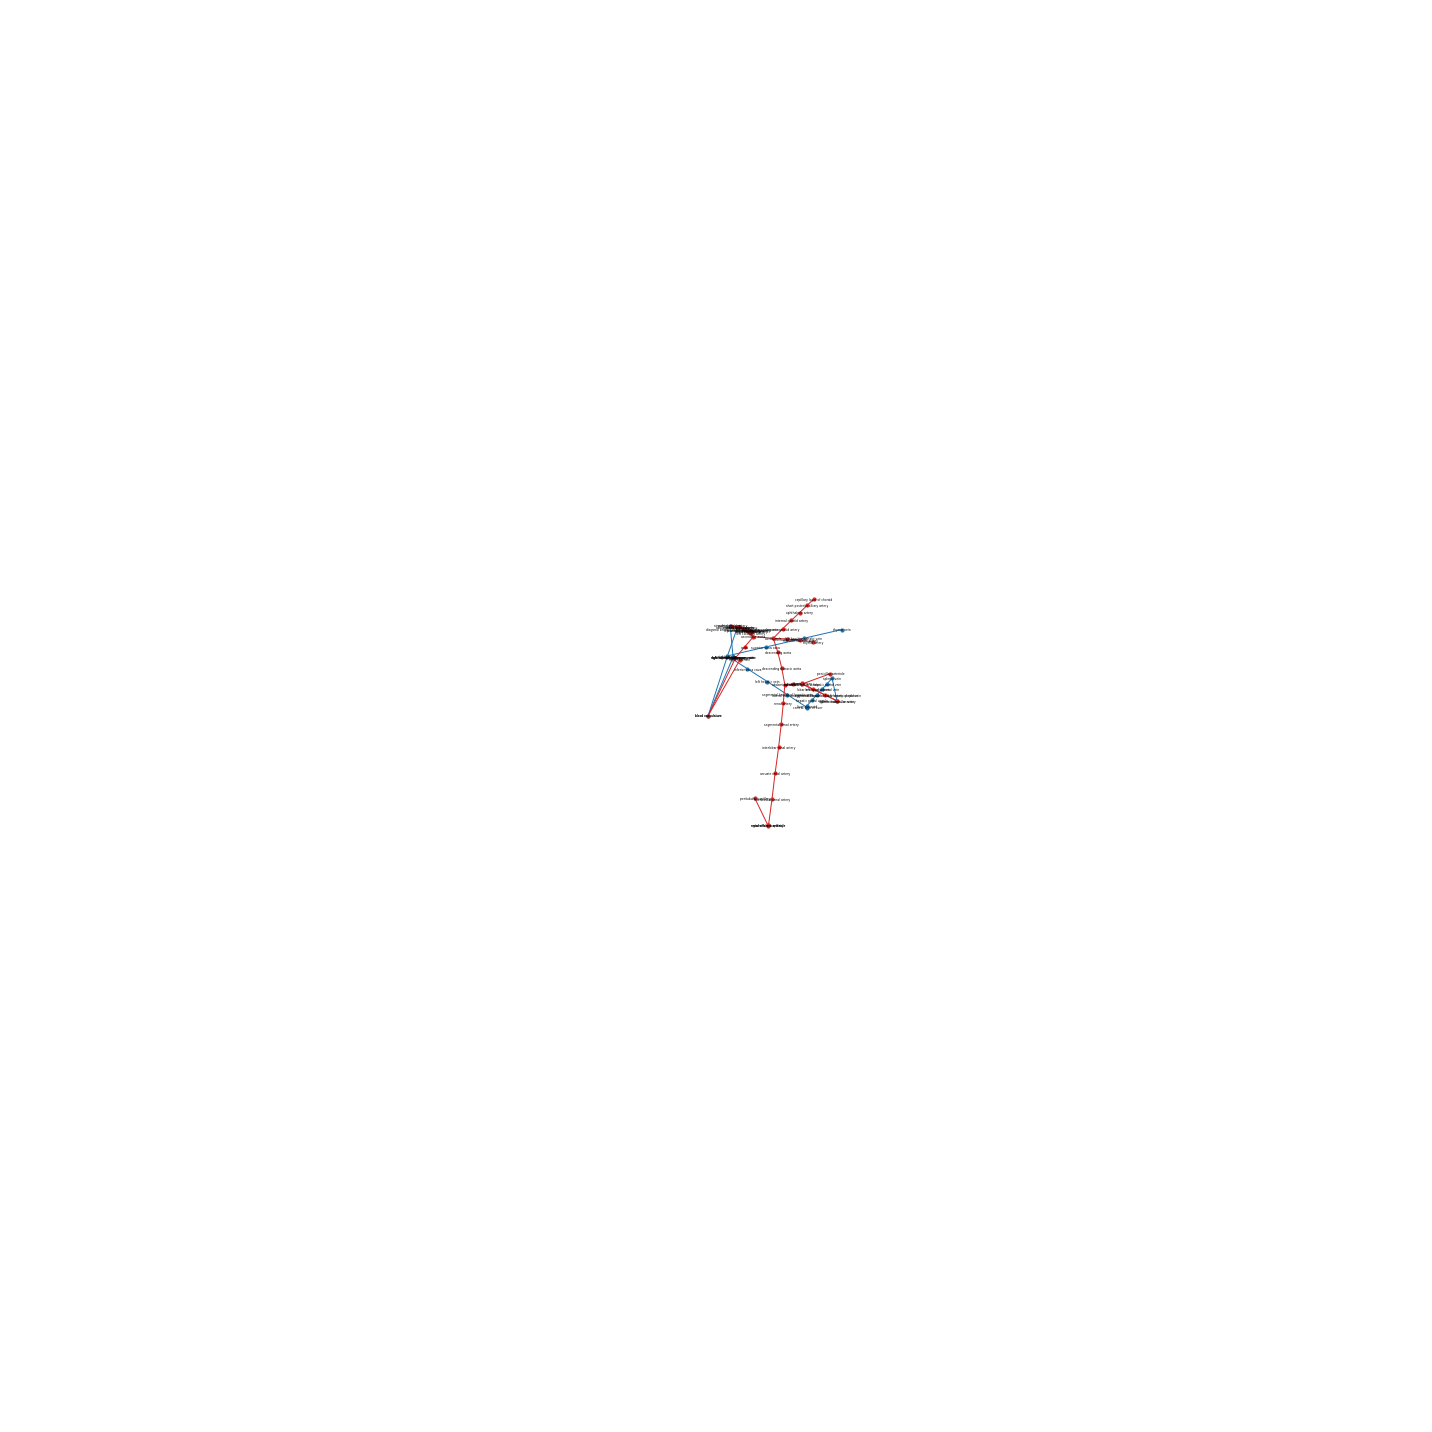

In [210]:
plot_fixed_graph2(pruned_vasc_graph_comp_male, male_wing_viz, draw_labels=True, filename='male_wing')

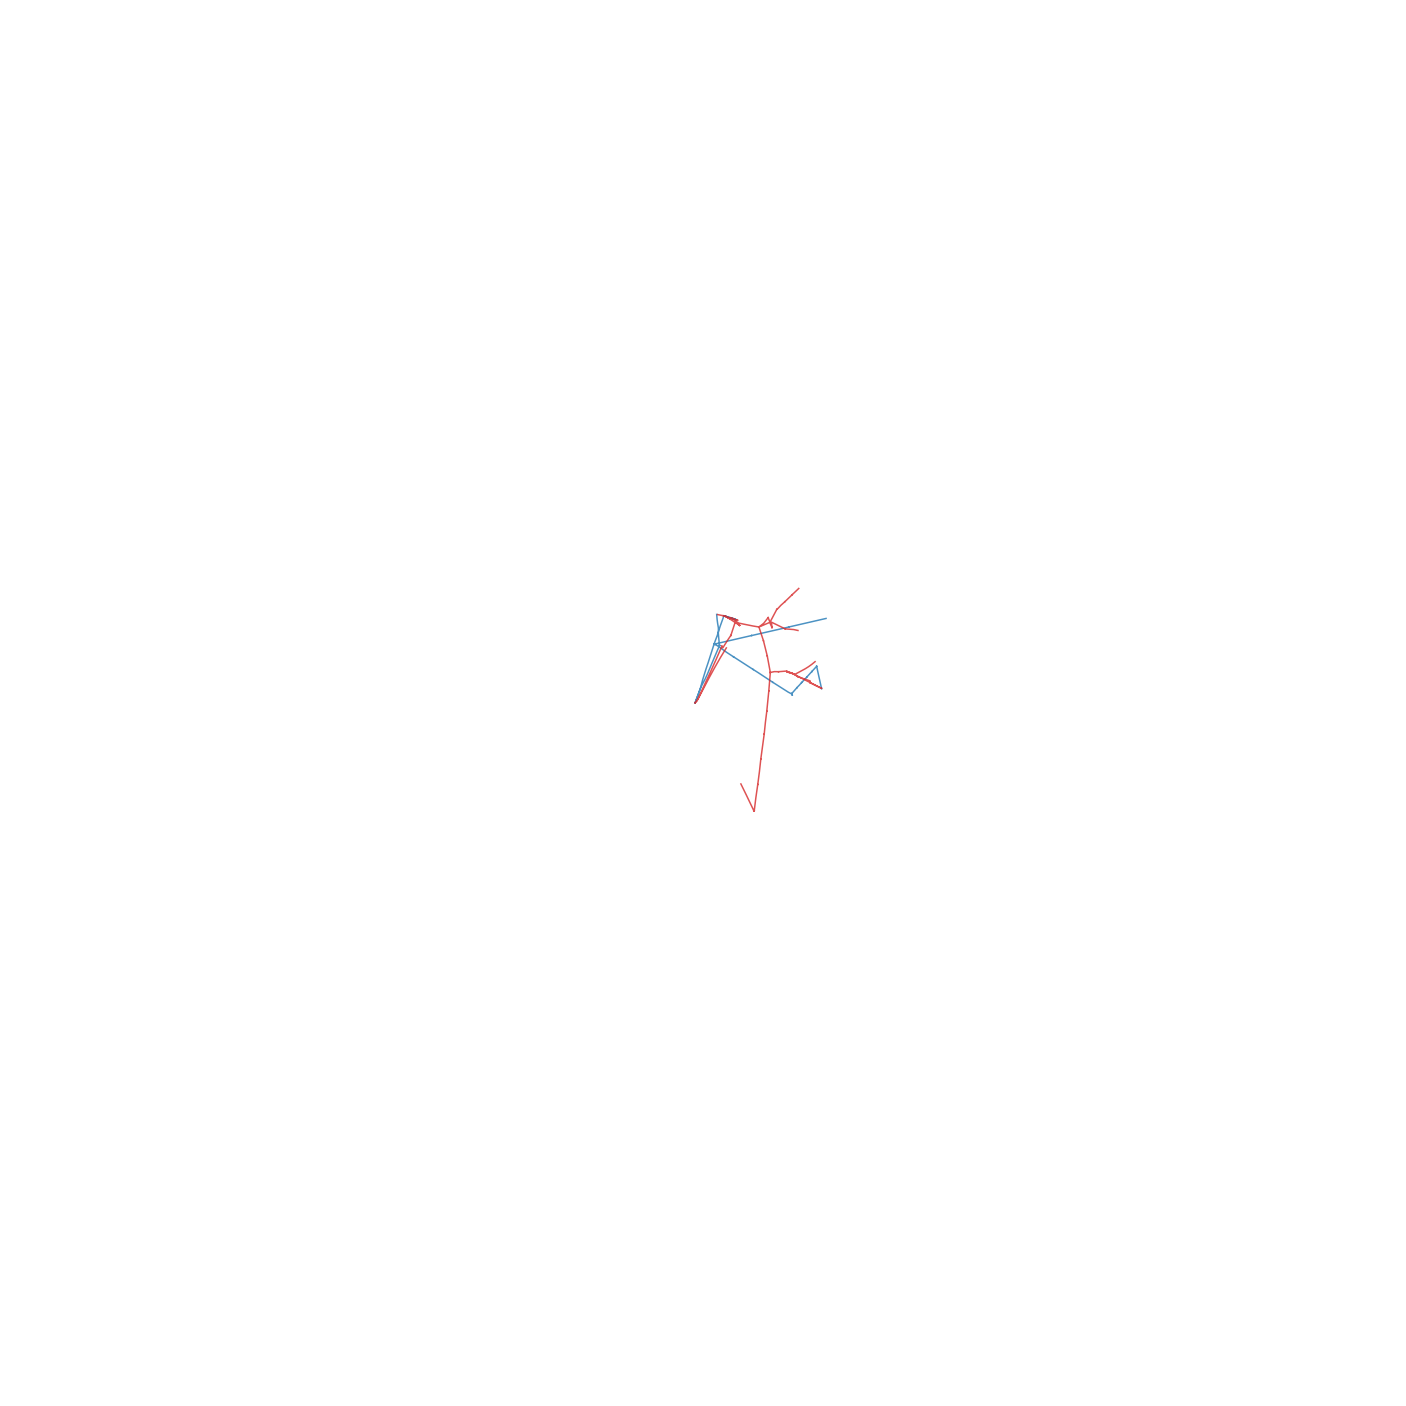

In [211]:
plot_fixed_graph2(pruned_vasc_graph_comp_male, male_wing_viz, bundle_edges=True, filename='male_wing')